This notebook serves to do initial EDA and feature engineering of the preprocessed MIMIC-IV data.

### Imports

In [136]:
import itertools
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as ss
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Set maximum rows and columns to display (None for unlimited)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 0)  # Adjust display width for console-like output
pd.set_option('display.max_colwidth', None)  # Show full content of each column

# Suppress scientific notation
pd.set_option('display.float_format', '{:.2f}'.format)

In [137]:
# Change working directory
wd = "C://Users//alexm//OneDrive//Desktop//Northwestern//Winter 2025//MSDS 498//Capstone Project//PE_Predictions//Data//Preprocessed_Data"
os.chdir(wd)

In [138]:
# Load data
df = pd.read_csv('preprocessed.csv')

# View first five rows of data
df.head()

,subject_id,hadm_id,dvt_date,pe_date,admission_type,admission_location,discharge_location,insurance,marital_status,race,gender,dvt_icd_code,dvt_icd_version,dvt_diagnosis,dvt_chronicity,dvt_location,pe_icd_code,pe_icd_version,pe_diagnosis,length_of_stay,num_dvt_admissions,num_dvt_diagnoses,had_dvt_as_pri_diagnosis,had_icu_stay,hx_ac,hx_dvt,hx_pe,hx_vte,pe_outcome,age,myocardial_infarct,congestive_heart_failure,peripheral_vascular_disease,cerebrovascular_disease,dementia,chronic_pulmonary_disease,rheumatic_disease,peptic_ulcer_disease,mild_liver_disease,diabetes_without_cc,diabetes_with_cc,paraplegia,renal_disease,malignant_cancer,severe_liver_disease,metastatic_solid_tumor,aids,charlson_comorbidity_index,had_ddimer,had_o2_sat,ac_flag,lytics_flag,mt_flag,us_cdt_flag,num_pe_events,cat_days_to_init_treatment,cat_days_to_pe
0,10000980,25242409,2191-04-03T18:48:00,NaN,EW EMER.,EMERGENCY ROOM,SKILLED NURSING FACILITY,Medicare,MARRIED,BLACK/AFRICAN AMERICAN,F,45342,9,Acute venous embolism and thrombosis of deep vessels of distal lower extremity,Acute,Lower,No PE,No PE,No PE,8,1,1,1,1,1,1,0,1,0,78,1,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,10,0,0,1,0,0,0,0,Same day,No PE
1,10001401,26840593,2131-06-19T21:32:00,2131-07-30T21:40:00,OBSERVATION ADMIT,EMERGENCY ROOM,SKILLED NURSING FACILITY,Medicare,MARRIED,WHITE,F,I82412,10,Acute embolism and thrombosis of left femoral vein,Acute,Lower,I2699,10.0,Other pulmonary embolism without acute cor pulmonale,13,2,2,0,0,1,1,1,1,1,89,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,6,0,0,1,0,0,0,1,Same day,1-3 months
2,10001919,29897682,2124-04-20T00:00:00,NaN,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL,HOME,Private,MARRIED,OTHER,M,I82621,10,Acute embolism and thrombosis of deep veins of right upper extremity,Acute,Upper,No PE,No PE,No PE,1,1,1,0,0,1,0,0,0,0,59,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,7,0,0,1,0,0,0,0,Same day,No PE
3,10002131,24065018,2128-03-17T14:53:00,NaN,EW EMER.,EMERGENCY ROOM,HOSPICE,Medicare,WIDOWED,WHITE,F,I82412,10,Acute embolism and thrombosis of left femoral vein,Acute,Lower,No PE,No PE,No PE,2,1,2,1,0,0,0,0,0,0,92,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,1,0,0,0,0,Same day,No PE
4,10002769,25681387,2174-07-06T18:37:00,NaN,EW EMER.,EMERGENCY ROOM,HOME HEALTH CARE,Private,SINGLE,BLACK/AFRICAN AMERICAN,F,45342,9,Acute venous embolism and thrombosis of deep vessels of distal lower extremity,Acute,Lower,No PE,No PE,No PE,2,1,1,1,0,1,1,0,1,0,59,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,Same day,No PE


In [139]:
# Dataset overview
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 57 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   subject_id                   4410 non-null   int64 
 1   hadm_id                      4410 non-null   int64 
 2   dvt_date                     4410 non-null   object
 3   pe_date                      217 non-null    object
 4   admission_type               4410 non-null   object
 5   admission_location           4410 non-null   object
 6   discharge_location           4410 non-null   object
 7   insurance                    4410 non-null   object
 8   marital_status               4410 non-null   object
 9   race                         4410 non-null   object
 10  gender                       4410 non-null   object
 11  dvt_icd_code                 4410 non-null   object
 12  dvt_icd_version              4410 non-null   int64 
 13  dvt_diagnosis                4410

In [140]:
# Change dvt_icd_version to "object" data type
df['dvt_icd_version'] = df['dvt_icd_version'].astype('object')

In [141]:
# Summary statistics
df.describe()

,subject_id,hadm_id,length_of_stay,num_dvt_admissions,num_dvt_diagnoses,had_dvt_as_pri_diagnosis,had_icu_stay,hx_ac,hx_dvt,hx_pe,hx_vte,pe_outcome,age,myocardial_infarct,congestive_heart_failure,peripheral_vascular_disease,cerebrovascular_disease,dementia,chronic_pulmonary_disease,rheumatic_disease,peptic_ulcer_disease,mild_liver_disease,diabetes_without_cc,diabetes_with_cc,paraplegia,renal_disease,malignant_cancer,severe_liver_disease,metastatic_solid_tumor,aids,charlson_comorbidity_index,had_ddimer,had_o2_sat,ac_flag,lytics_flag,mt_flag,us_cdt_flag,num_pe_events
count,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00
mean,14996209.27,24961380.89,12.12,1.35,1.67,0.24,0.56,0.52,0.49,0.13,0.51,0.05,63.68,0.08,0.18,0.09,0.10,0.04,0.19,0.04,0.03,0.10,0.20,0.09,0.04,0.21,0.25,0.05,0.14,0.01,4.94,0.03,0.11,0.93,0.10,0.02,0.02,0.06
std,2877779.37,2936644.69,16.48,0.95,1.48,0.43,0.50,0.50,0.50,0.33,0.50,0.22,16.51,0.27,0.38,0.28,0.31,0.20,0.39,0.19,0.16,0.30,0.40,0.29,0.20,0.41,0.43,0.21,0.35,0.08,3.22,0.16,0.31,0.26,0.31,0.12,0.14,0.33
min,10000980.00,20001446.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,18.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,12502405.25,22355068.50,3.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,54.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
50%,15000086.00,24935067.50,7.00,1.00,1.00,0.00,1.00,1.00,0.00,0.00,1.00,0.00,65.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
75%,17521280.50,27554096.25,15.00,1.00,2.00,0.00,1.00,1.00,1.00,0.00,1.00,0.00,76.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,7.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
max,19992875.00,29998932.00,296.00,25.00,48.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,100.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,16.00,1.00,1.00,1.00,1.00,1.00,1.00,6.00


### Exploratory Data Analysis
#### Univariate Analysis
##### Histograms for Numeric Fields

<Figure size 600x400 with 0 Axes>

(array([2.749e+03, 8.760e+02, 3.870e+02, 1.570e+02, 9.500e+01, 5.700e+01,
        2.300e+01, 1.900e+01, 1.300e+01, 1.100e+01, 5.000e+00, 6.000e+00,
        6.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 2.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([  0.        ,   9.86666667,  19.73333333,  29.6       ,
         39.46666667,  49.33333333,  59.2       ,  69.06666667,
         78.93333333,  88.8       ,  98.66666667, 108.53333333,
        118.4       , 128.26666667, 138.13333333, 148.        ,
        157.86666667, 167.73333333, 177.6       , 187.46666667,
        197.33333333, 207.2       , 217.06666667, 226.93333333,
        236.8       , 246.66666667, 256.53333333, 266.4       ,
        276.26666667, 286.13333333, 296.        ]),
 <BarContainer object of 30 artists>)

Text(0.5, 1.0, 'Histogram of length_of_stay')

Text(0.5, 0, 'length_of_stay')

Text(0, 0.5, 'Count')

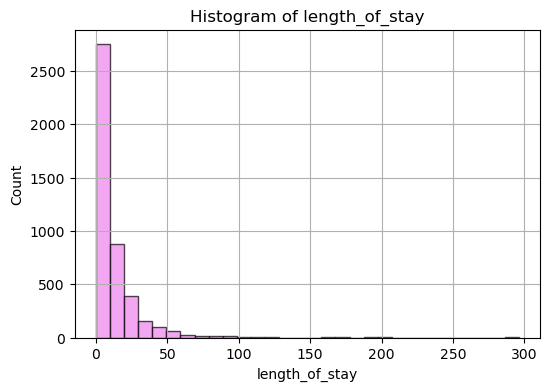

<Figure size 600x400 with 0 Axes>

(array([3.443e+03, 6.620e+02, 1.770e+02, 7.000e+01, 0.000e+00, 2.700e+01,
        6.000e+00, 9.000e+00, 7.000e+00, 0.000e+00, 4.000e+00, 2.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([ 1. ,  1.8,  2.6,  3.4,  4.2,  5. ,  5.8,  6.6,  7.4,  8.2,  9. ,
         9.8, 10.6, 11.4, 12.2, 13. , 13.8, 14.6, 15.4, 16.2, 17. , 17.8,
        18.6, 19.4, 20.2, 21. , 21.8, 22.6, 23.4, 24.2, 25. ]),
 <BarContainer object of 30 artists>)

Text(0.5, 1.0, 'Histogram of num_dvt_admissions')

Text(0.5, 0, 'num_dvt_admissions')

Text(0, 0.5, 'Count')

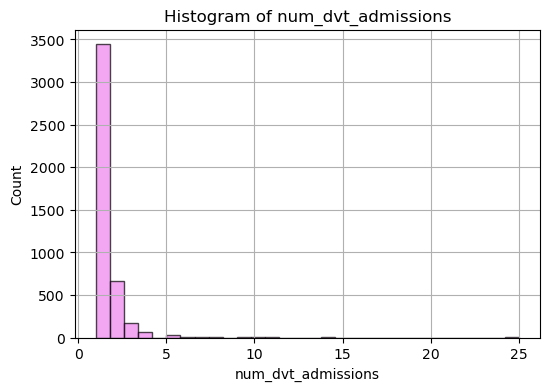

<Figure size 600x400 with 0 Axes>

(array([3.766e+03, 4.820e+02, 6.500e+01, 5.700e+01, 1.100e+01, 1.800e+01,
        3.000e+00, 4.000e+00, 3.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([ 1.        ,  2.56666667,  4.13333333,  5.7       ,  7.26666667,
         8.83333333, 10.4       , 11.96666667, 13.53333333, 15.1       ,
        16.66666667, 18.23333333, 19.8       , 21.36666667, 22.93333333,
        24.5       , 26.06666667, 27.63333333, 29.2       , 30.76666667,
        32.33333333, 33.9       , 35.46666667, 37.03333333, 38.6       ,
        40.16666667, 41.73333333, 43.3       , 44.86666667, 46.43333333,
        48.        ]),
 <BarContainer object of 30 artists>)

Text(0.5, 1.0, 'Histogram of num_dvt_diagnoses')

Text(0.5, 0, 'num_dvt_diagnoses')

Text(0, 0.5, 'Count')

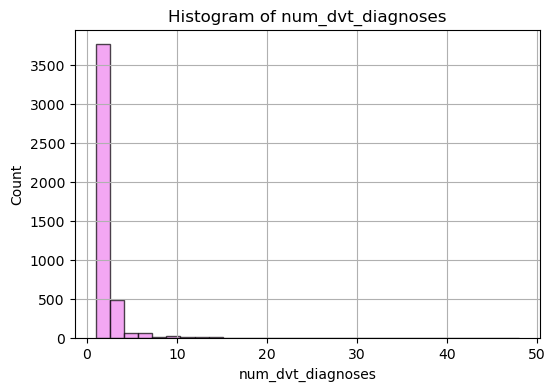

<Figure size 600x400 with 0 Axes>

(array([ 24.,  31.,  43.,  44.,  55.,  71.,  80.,  71., 100., 116., 160.,
        106., 199., 227., 210., 302., 319., 317., 220., 301., 283., 260.,
        140., 212., 182., 145., 129.,  47.,  15.,   1.]),
 array([ 18.        ,  20.73333333,  23.46666667,  26.2       ,
         28.93333333,  31.66666667,  34.4       ,  37.13333333,
         39.86666667,  42.6       ,  45.33333333,  48.06666667,
         50.8       ,  53.53333333,  56.26666667,  59.        ,
         61.73333333,  64.46666667,  67.2       ,  69.93333333,
         72.66666667,  75.4       ,  78.13333333,  80.86666667,
         83.6       ,  86.33333333,  89.06666667,  91.8       ,
         94.53333333,  97.26666667, 100.        ]),
 <BarContainer object of 30 artists>)

Text(0.5, 1.0, 'Histogram of age')

Text(0.5, 0, 'age')

Text(0, 0.5, 'Count')

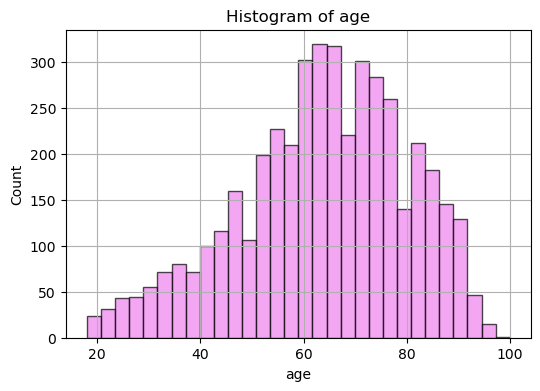

<Figure size 600x400 with 0 Axes>

(array([380., 325.,   0., 439.,   0., 439.,   0., 503.,   0., 521.,   0.,
        451.,   0., 400.,   0., 314., 250.,   0., 145.,   0., 119.,   0.,
         60.,   0.,  37.,   0.,  11.,   0.,  10.,   6.]),
 array([ 0.        ,  0.53333333,  1.06666667,  1.6       ,  2.13333333,
         2.66666667,  3.2       ,  3.73333333,  4.26666667,  4.8       ,
         5.33333333,  5.86666667,  6.4       ,  6.93333333,  7.46666667,
         8.        ,  8.53333333,  9.06666667,  9.6       , 10.13333333,
        10.66666667, 11.2       , 11.73333333, 12.26666667, 12.8       ,
        13.33333333, 13.86666667, 14.4       , 14.93333333, 15.46666667,
        16.        ]),
 <BarContainer object of 30 artists>)

Text(0.5, 1.0, 'Histogram of charlson_comorbidity_index')

Text(0.5, 0, 'charlson_comorbidity_index')

Text(0, 0.5, 'Count')

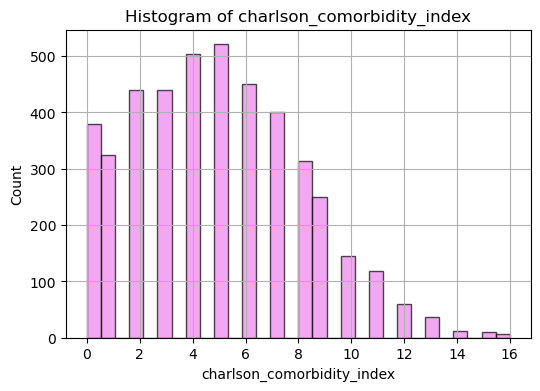

<Figure size 600x400 with 0 Axes>

(array([4.193e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.720e+02,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 3.300e+01, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 7.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4,
        2.6, 2.8, 3. , 3.2, 3.4, 3.6, 3.8, 4. , 4.2, 4.4, 4.6, 4.8, 5. ,
        5.2, 5.4, 5.6, 5.8, 6. ]),
 <BarContainer object of 30 artists>)

Text(0.5, 1.0, 'Histogram of num_pe_events')

Text(0.5, 0, 'num_pe_events')

Text(0, 0.5, 'Count')

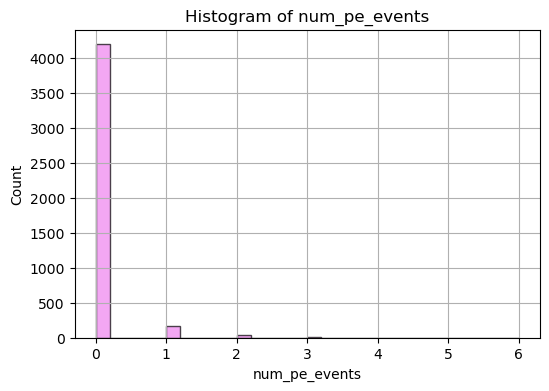

In [142]:
# Identify numeric columns (that aren't binary or identifiers)
num_cols = ['length_of_stay', 'num_dvt_admissions', 'num_dvt_diagnoses', 'age', 'charlson_comorbidity_index', 'num_pe_events']

for col in num_cols:
    plt.figure(figsize = (6, 4))
    plt.hist(df[col], bins = 30, alpha = 0.7, color = "violet", edgecolor = "black")
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.grid(True)
    plt.show()

##### Boxplots for Outlier Detection

<Figure size 600x400 with 0 Axes>

<AxesSubplot:xlabel='length_of_stay'>

Text(0.5, 1.0, 'Boxplot of length_of_stay')

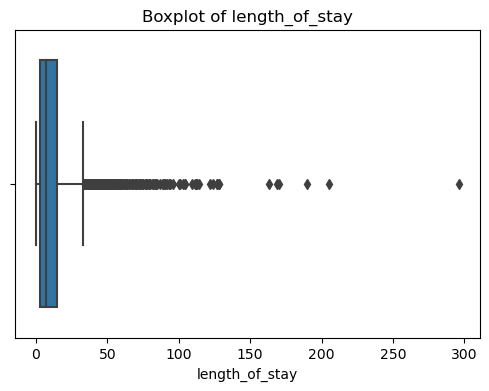

<Figure size 600x400 with 0 Axes>

<AxesSubplot:xlabel='num_dvt_admissions'>

Text(0.5, 1.0, 'Boxplot of num_dvt_admissions')

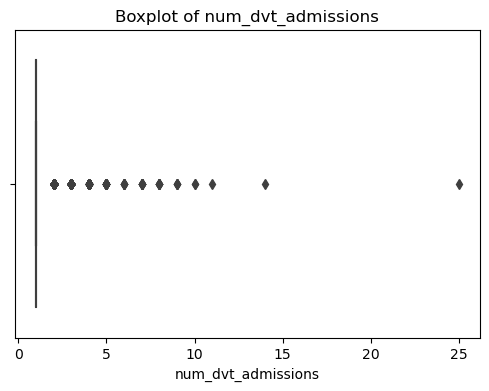

<Figure size 600x400 with 0 Axes>

<AxesSubplot:xlabel='num_dvt_diagnoses'>

Text(0.5, 1.0, 'Boxplot of num_dvt_diagnoses')

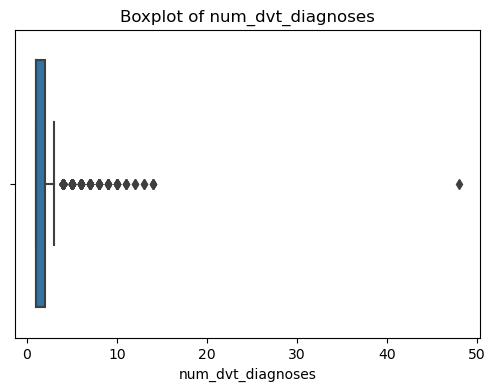

<Figure size 600x400 with 0 Axes>

<AxesSubplot:xlabel='age'>

Text(0.5, 1.0, 'Boxplot of age')

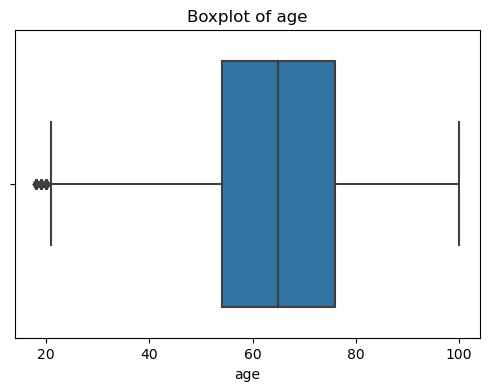

<Figure size 600x400 with 0 Axes>

<AxesSubplot:xlabel='charlson_comorbidity_index'>

Text(0.5, 1.0, 'Boxplot of charlson_comorbidity_index')

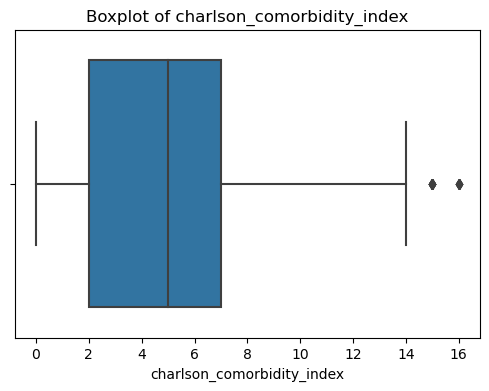

<Figure size 600x400 with 0 Axes>

<AxesSubplot:xlabel='num_pe_events'>

Text(0.5, 1.0, 'Boxplot of num_pe_events')

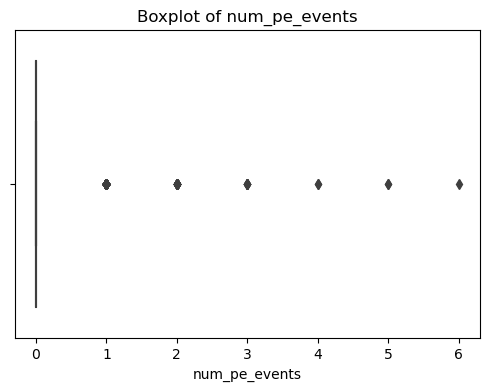

In [143]:
# Plot boxplots
for col in num_cols:
    plt.figure(figsize = (6, 4))
    sns.boxplot(x = df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

In [144]:
r_skewed = ['length_of_stay', 'num_dvt_admissions', 'num_dvt_diagnoses']

# Transform right-skewed numeric fields 
# Apply log(1 + x) transformation and create new columns with 'log_' prefix
for col in r_skewed:
    df[f'log_{col}'] = np.log1p(df[col])  # log(1 + x) transformation    

# Validate that new columns were created
df.describe()

,subject_id,hadm_id,length_of_stay,num_dvt_admissions,num_dvt_diagnoses,had_dvt_as_pri_diagnosis,had_icu_stay,hx_ac,hx_dvt,hx_pe,hx_vte,pe_outcome,age,myocardial_infarct,congestive_heart_failure,peripheral_vascular_disease,cerebrovascular_disease,dementia,chronic_pulmonary_disease,rheumatic_disease,peptic_ulcer_disease,mild_liver_disease,diabetes_without_cc,diabetes_with_cc,paraplegia,renal_disease,malignant_cancer,severe_liver_disease,metastatic_solid_tumor,aids,charlson_comorbidity_index,had_ddimer,had_o2_sat,ac_flag,lytics_flag,mt_flag,us_cdt_flag,num_pe_events,log_length_of_stay,log_num_dvt_admissions,log_num_dvt_diagnoses
count,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00
mean,14996209.27,24961380.89,12.12,1.35,1.67,0.24,0.56,0.52,0.49,0.13,0.51,0.05,63.68,0.08,0.18,0.09,0.10,0.04,0.19,0.04,0.03,0.10,0.20,0.09,0.04,0.21,0.25,0.05,0.14,0.01,4.94,0.03,0.11,0.93,0.10,0.02,0.02,0.06,2.10,0.81,0.91
std,2877779.37,2936644.69,16.48,0.95,1.48,0.43,0.50,0.50,0.50,0.33,0.50,0.22,16.51,0.27,0.38,0.28,0.31,0.20,0.39,0.19,0.16,0.30,0.40,0.29,0.20,0.41,0.43,0.21,0.35,0.08,3.22,0.16,0.31,0.26,0.31,0.12,0.14,0.33,0.95,0.26,0.35
min,10000980.00,20001446.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,18.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.69,0.69
25%,12502405.25,22355068.50,3.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,54.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.39,0.69,0.69
50%,15000086.00,24935067.50,7.00,1.00,1.00,0.00,1.00,1.00,0.00,0.00,1.00,0.00,65.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,2.08,0.69,0.69
75%,17521280.50,27554096.25,15.00,1.00,2.00,0.00,1.00,1.00,1.00,0.00,1.00,0.00,76.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,7.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,2.77,0.69,1.10
max,19992875.00,29998932.00,296.00,25.00,48.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,100.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,16.00,1.00,1.00,1.00,1.00,1.00,1.00,6.00,5.69,3.26,3.89


<Figure size 600x400 with 0 Axes>

<AxesSubplot:xlabel='log_length_of_stay'>

Text(0.5, 1.0, 'Boxplot of log_length_of_stay')

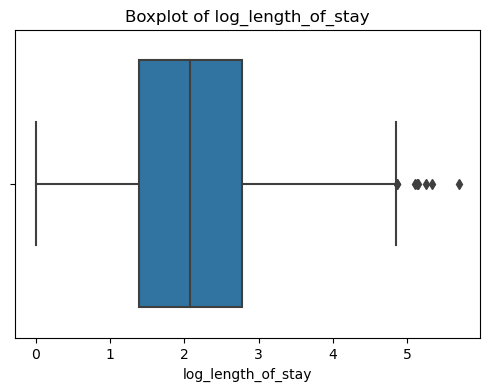

<Figure size 600x400 with 0 Axes>

<AxesSubplot:xlabel='log_num_dvt_admissions'>

Text(0.5, 1.0, 'Boxplot of log_num_dvt_admissions')

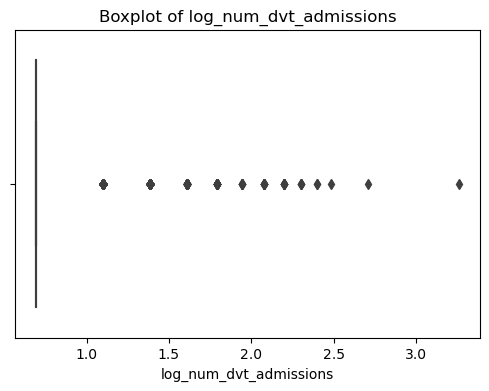

<Figure size 600x400 with 0 Axes>

<AxesSubplot:xlabel='log_num_dvt_diagnoses'>

Text(0.5, 1.0, 'Boxplot of log_num_dvt_diagnoses')

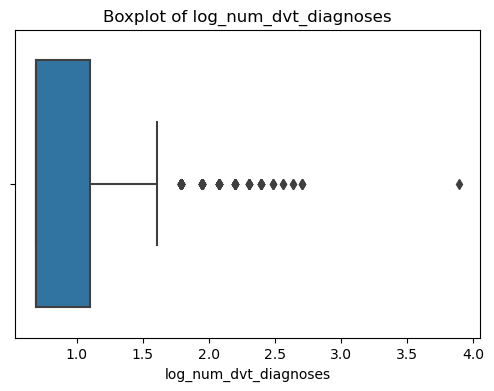

In [145]:
# Plot boxplots for log_ columns to see outliers now
for col in ['log_length_of_stay', 'log_num_dvt_admissions', 'log_num_dvt_diagnoses']:
    plt.figure(figsize = (6, 4))
    sns.boxplot(x = df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

##### Value Counts for Categorical Fields

Findings:
- Consider consolidating admission_type, admission_location, and discharge_location
- Consolidate race field
- Drop dvt_icd_code, dvt_icd_version, and dvt_diagnosis for modeling because relevant info (DVT location and chronicity) have already been extracted and added as separate fields
- Drop pe_icd_code, pe_icd_version, and pe_diagnosis for modeling because we are only interested in whether a PE event occurred or not 
- Drop cat_days_to_pe because this is more for exploratory purposes
-----
- About half of the admissions were to the ER
- Top three discharge locations were home, home health care, and skilled nursing facility
- Over half of the subjects had Medicare at time of admission
- About half of the subjects were married at time of admission
- Majority race is White
- Slightly more than half of the subjects are male
- Majority of DVTs were acute
- Diagnoses were more often lower (~2500 records) than upper (~1500 records) DVTs
- Majority of subjects received initial treatment on same day of admission
- About 25% of subjects had DVT as their primary diagnosis --> look at how many of these ended up with a PE event
- Over half of the patients had an ICU stay
- Over half of the patients had a history of AC use
- There is about a 50/50 split of history of DVT
- Majority of subjects did not have a history of PE
- About 5% of patients had a PE event (target field) --> most common timeframe was more than 1 year after DVT diagnosis, second most common was within 1 month of DVT diagnosis
- Out of the Charlson comorbidities, the top 5 most common conditions were malignant cancer, renal disease, diabetes without chronic complications, chronic pulmonary disease, and congestive heart failure
- Majority of patients did not have d-dimer or oxygen saturation labs done
- Most common treatment found was AC, followed by thrombolytics, CDT, and then MT

<Figure size 800x400 with 0 Axes>

<AxesSubplot:xlabel='count', ylabel='dvt_date'>

Text(0.5, 1.0, 'Distribution of dvt_date')

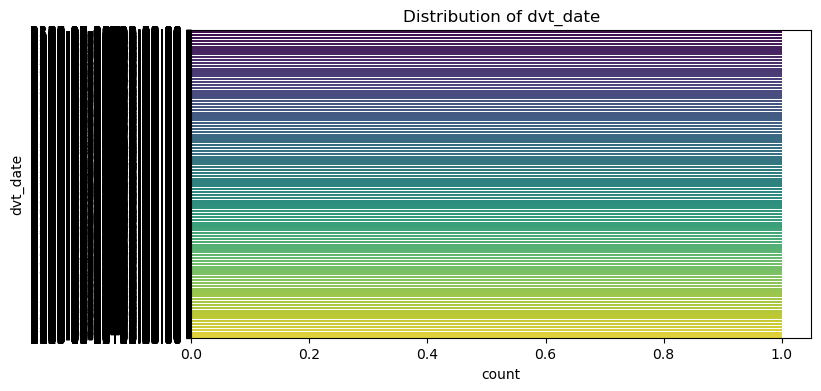

<Figure size 800x400 with 0 Axes>

<AxesSubplot:xlabel='count', ylabel='pe_date'>

Text(0.5, 1.0, 'Distribution of pe_date')

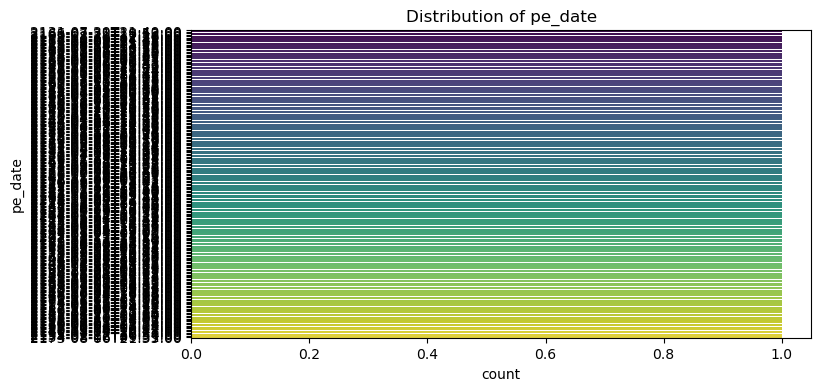

<Figure size 800x400 with 0 Axes>

<AxesSubplot:xlabel='count', ylabel='admission_type'>

Text(0.5, 1.0, 'Distribution of admission_type')

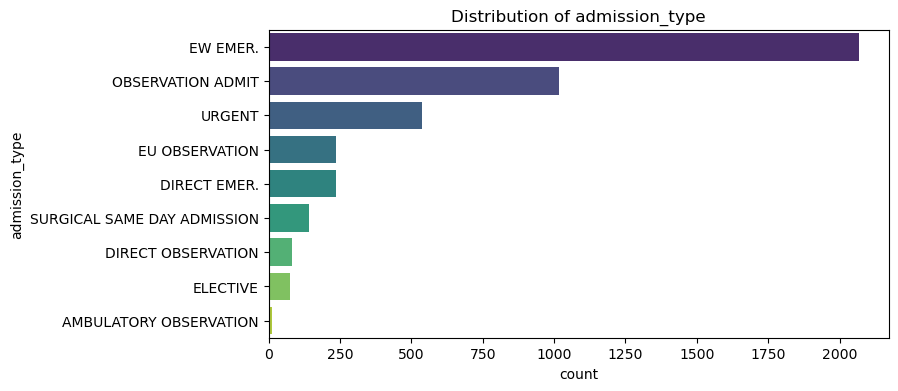

<Figure size 800x400 with 0 Axes>

<AxesSubplot:xlabel='count', ylabel='admission_location'>

Text(0.5, 1.0, 'Distribution of admission_location')

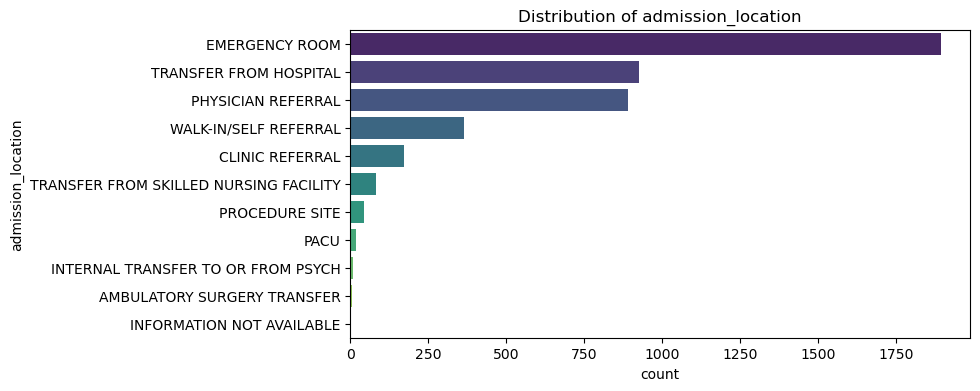

<Figure size 800x400 with 0 Axes>

<AxesSubplot:xlabel='count', ylabel='discharge_location'>

Text(0.5, 1.0, 'Distribution of discharge_location')

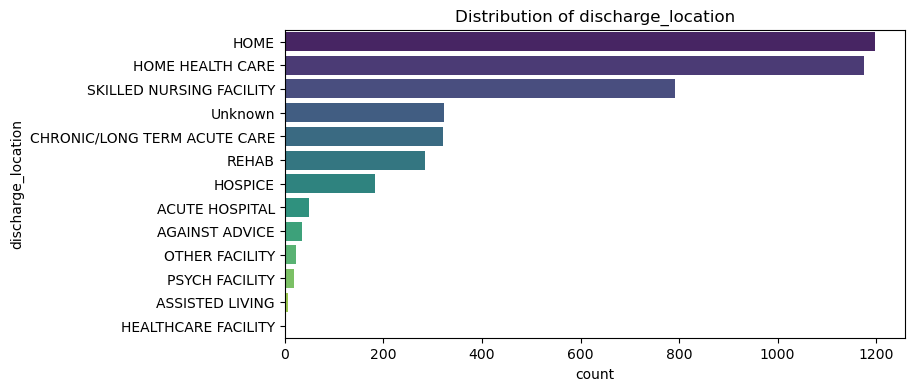

<Figure size 800x400 with 0 Axes>

<AxesSubplot:xlabel='count', ylabel='insurance'>

Text(0.5, 1.0, 'Distribution of insurance')

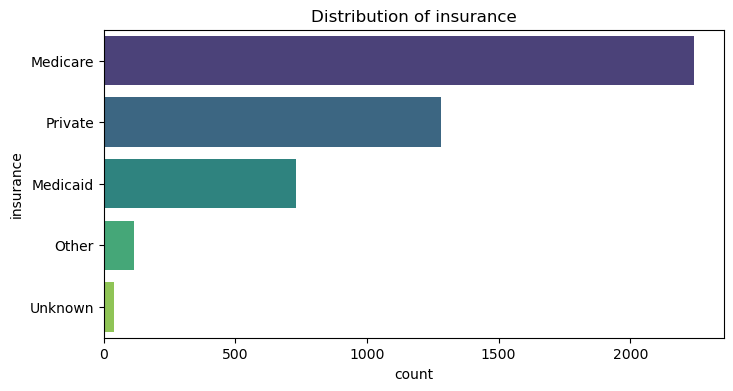

<Figure size 800x400 with 0 Axes>

<AxesSubplot:xlabel='count', ylabel='marital_status'>

Text(0.5, 1.0, 'Distribution of marital_status')

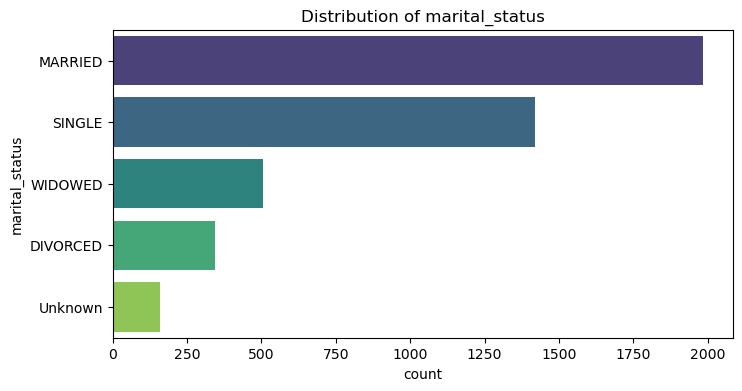

<Figure size 800x400 with 0 Axes>

<AxesSubplot:xlabel='count', ylabel='race'>

Text(0.5, 1.0, 'Distribution of race')

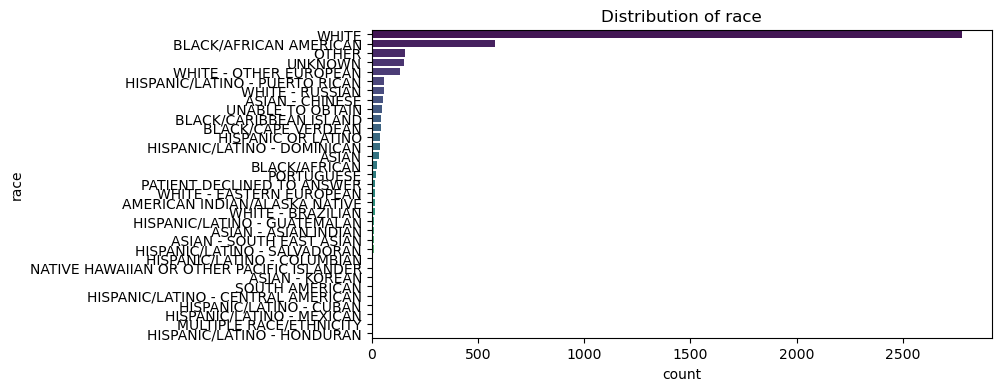

<Figure size 800x400 with 0 Axes>

<AxesSubplot:xlabel='count', ylabel='gender'>

Text(0.5, 1.0, 'Distribution of gender')

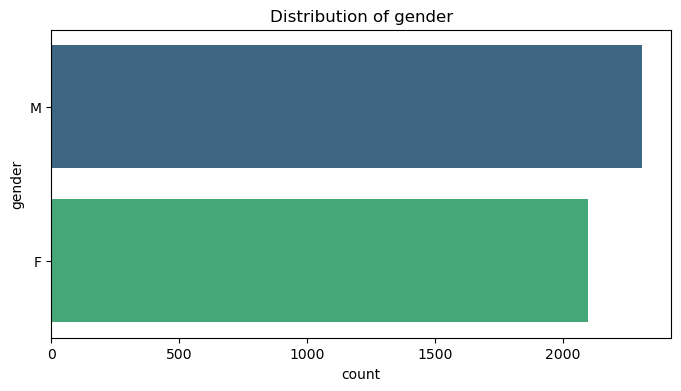

<Figure size 800x400 with 0 Axes>

<AxesSubplot:xlabel='count', ylabel='dvt_icd_code'>

Text(0.5, 1.0, 'Distribution of dvt_icd_code')

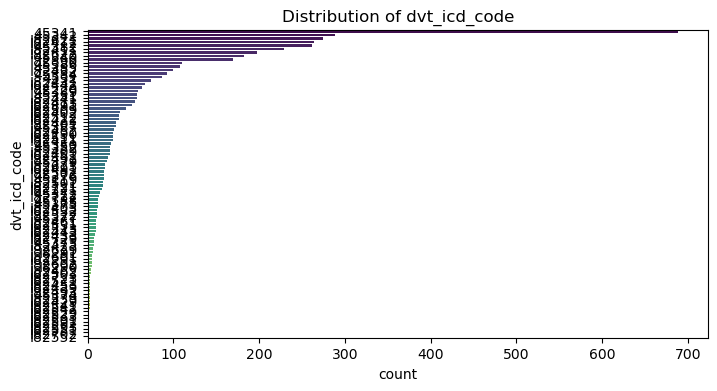

<Figure size 800x400 with 0 Axes>

<AxesSubplot:xlabel='count', ylabel='dvt_icd_version'>

Text(0.5, 1.0, 'Distribution of dvt_icd_version')

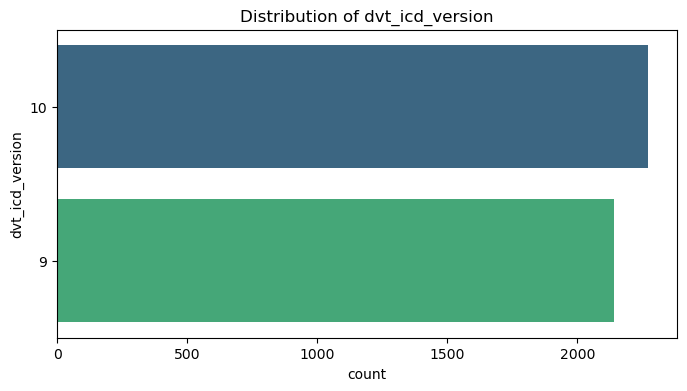

<Figure size 800x400 with 0 Axes>

<AxesSubplot:xlabel='count', ylabel='dvt_diagnosis'>

Text(0.5, 1.0, 'Distribution of dvt_diagnosis')

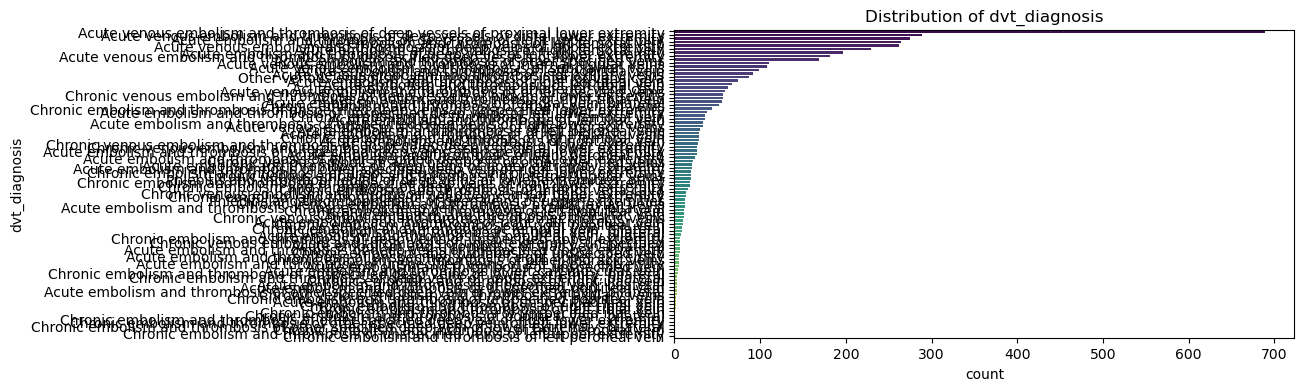

<Figure size 800x400 with 0 Axes>

<AxesSubplot:xlabel='count', ylabel='dvt_chronicity'>

Text(0.5, 1.0, 'Distribution of dvt_chronicity')

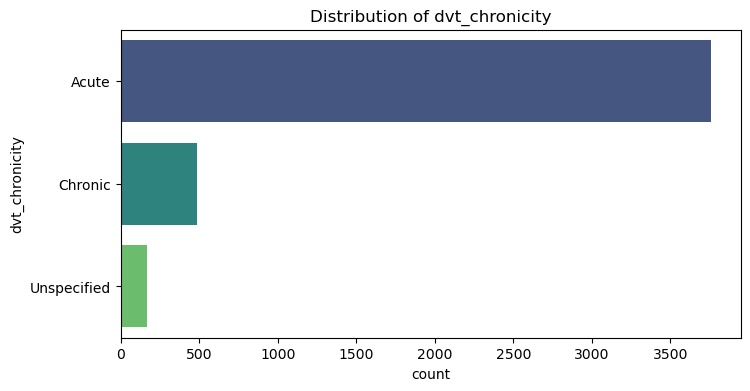

<Figure size 800x400 with 0 Axes>

<AxesSubplot:xlabel='count', ylabel='dvt_location'>

Text(0.5, 1.0, 'Distribution of dvt_location')

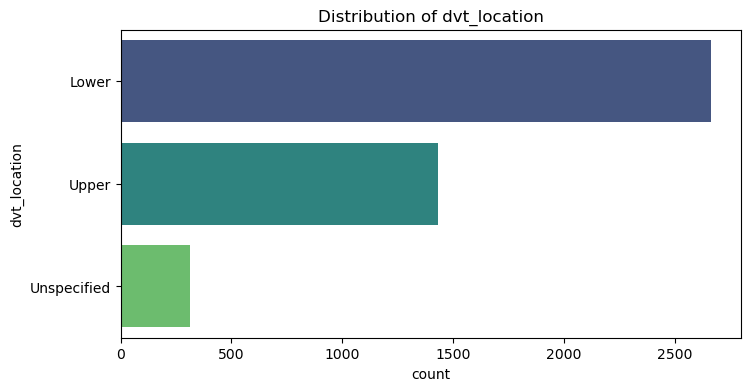

<Figure size 800x400 with 0 Axes>

<AxesSubplot:xlabel='count', ylabel='pe_icd_code'>

Text(0.5, 1.0, 'Distribution of pe_icd_code')

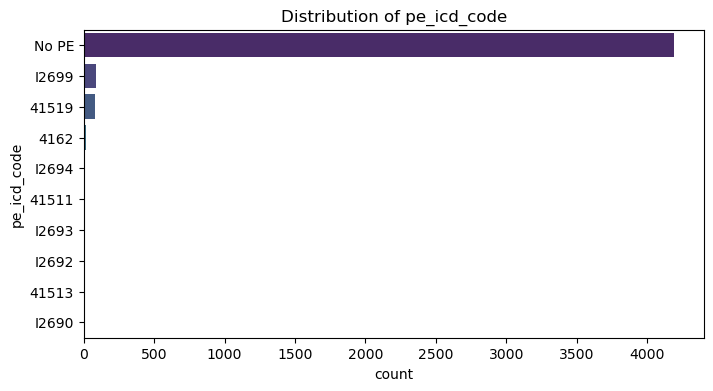

<Figure size 800x400 with 0 Axes>

<AxesSubplot:xlabel='count', ylabel='pe_icd_version'>

Text(0.5, 1.0, 'Distribution of pe_icd_version')

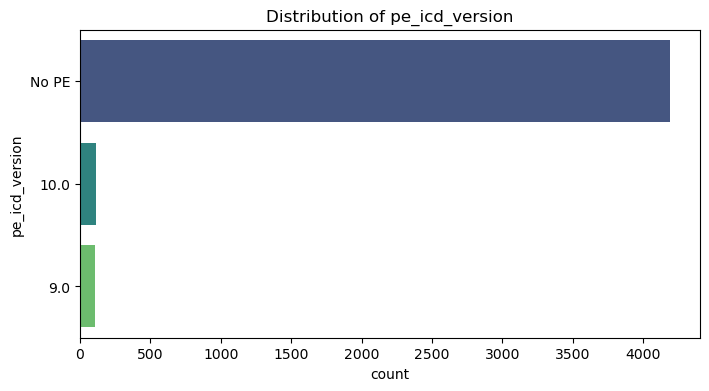

<Figure size 800x400 with 0 Axes>

<AxesSubplot:xlabel='count', ylabel='pe_diagnosis'>

Text(0.5, 1.0, 'Distribution of pe_diagnosis')

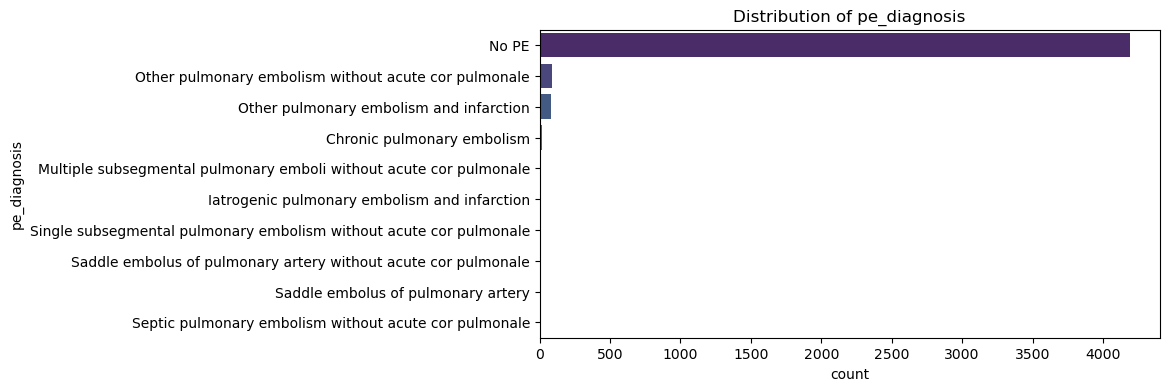

<Figure size 800x400 with 0 Axes>

<AxesSubplot:xlabel='count', ylabel='cat_days_to_init_treatment'>

Text(0.5, 1.0, 'Distribution of cat_days_to_init_treatment')

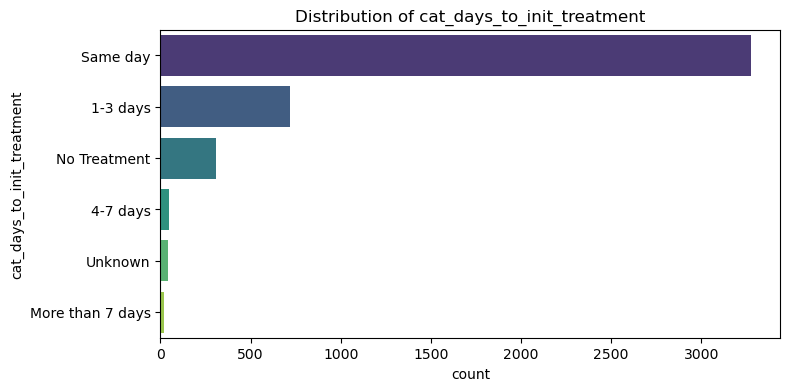

<Figure size 800x400 with 0 Axes>

<AxesSubplot:xlabel='count', ylabel='cat_days_to_pe'>

Text(0.5, 1.0, 'Distribution of cat_days_to_pe')

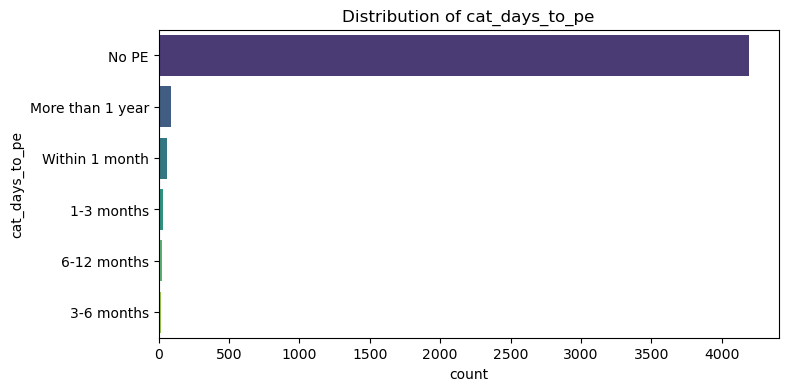

<Figure size 800x400 with 0 Axes>

<AxesSubplot:xlabel='count', ylabel='had_dvt_as_pri_diagnosis'>

Text(0.5, 1.0, 'Distribution of had_dvt_as_pri_diagnosis')

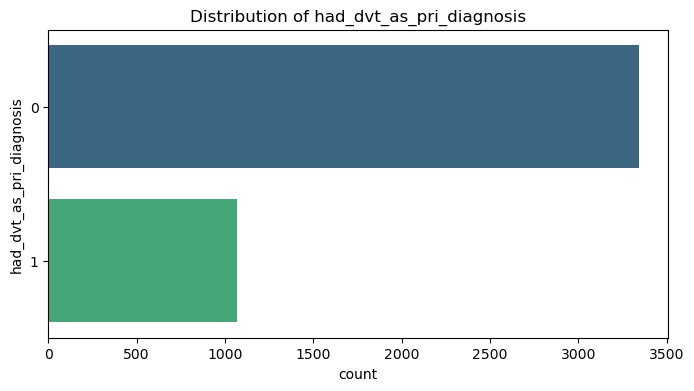

<Figure size 800x400 with 0 Axes>

<AxesSubplot:xlabel='count', ylabel='had_icu_stay'>

Text(0.5, 1.0, 'Distribution of had_icu_stay')

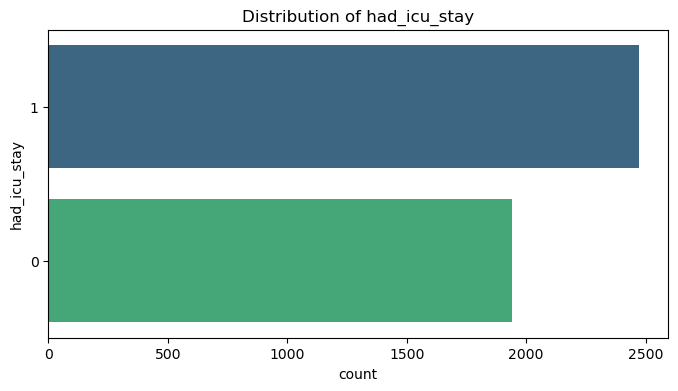

<Figure size 800x400 with 0 Axes>

<AxesSubplot:xlabel='count', ylabel='hx_ac'>

Text(0.5, 1.0, 'Distribution of hx_ac')

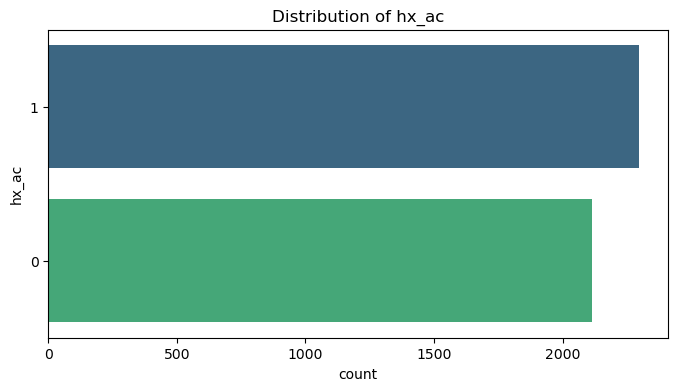

<Figure size 800x400 with 0 Axes>

<AxesSubplot:xlabel='count', ylabel='hx_dvt'>

Text(0.5, 1.0, 'Distribution of hx_dvt')

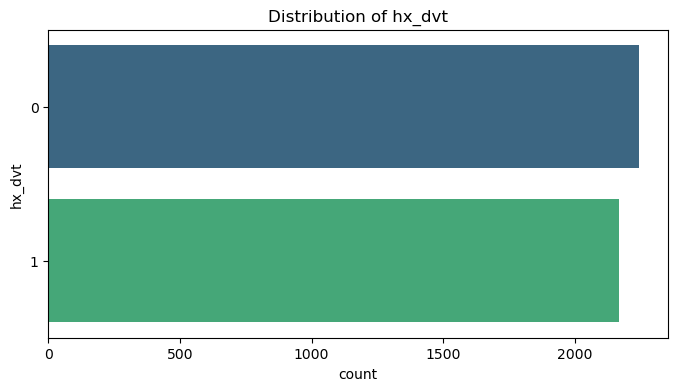

<Figure size 800x400 with 0 Axes>

<AxesSubplot:xlabel='count', ylabel='hx_pe'>

Text(0.5, 1.0, 'Distribution of hx_pe')

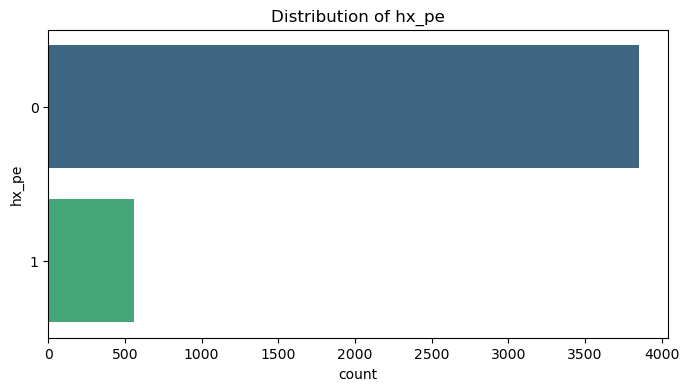

<Figure size 800x400 with 0 Axes>

<AxesSubplot:xlabel='count', ylabel='hx_vte'>

Text(0.5, 1.0, 'Distribution of hx_vte')

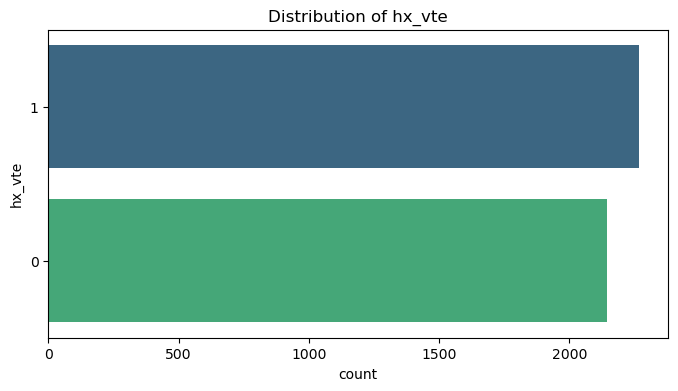

<Figure size 800x400 with 0 Axes>

<AxesSubplot:xlabel='count', ylabel='pe_outcome'>

Text(0.5, 1.0, 'Distribution of pe_outcome')

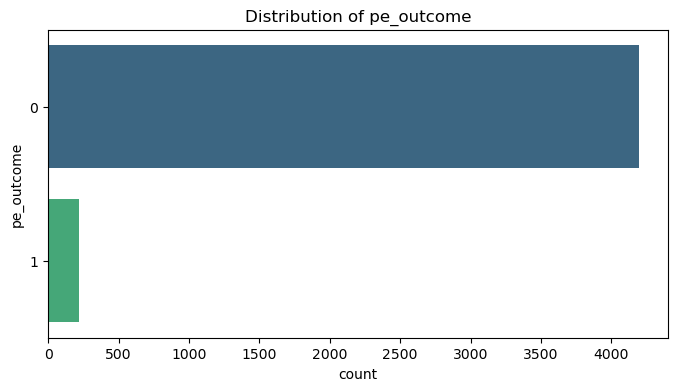

<Figure size 800x400 with 0 Axes>

<AxesSubplot:xlabel='count', ylabel='myocardial_infarct'>

Text(0.5, 1.0, 'Distribution of myocardial_infarct')

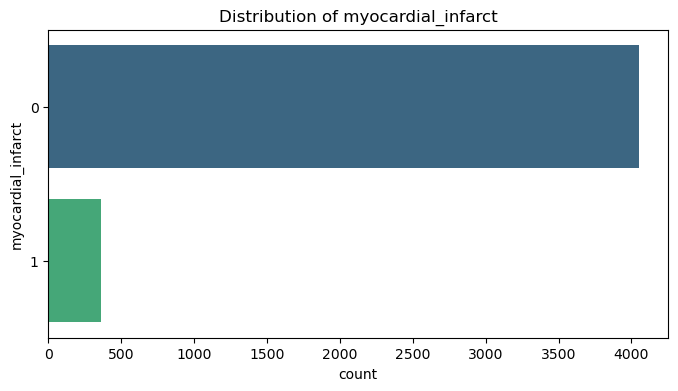

<Figure size 800x400 with 0 Axes>

<AxesSubplot:xlabel='count', ylabel='congestive_heart_failure'>

Text(0.5, 1.0, 'Distribution of congestive_heart_failure')

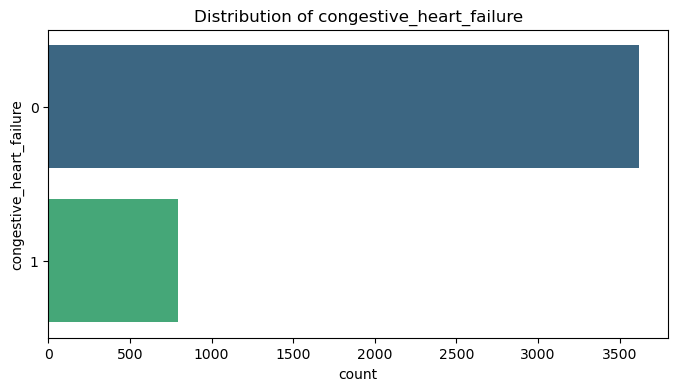

<Figure size 800x400 with 0 Axes>

<AxesSubplot:xlabel='count', ylabel='peripheral_vascular_disease'>

Text(0.5, 1.0, 'Distribution of peripheral_vascular_disease')

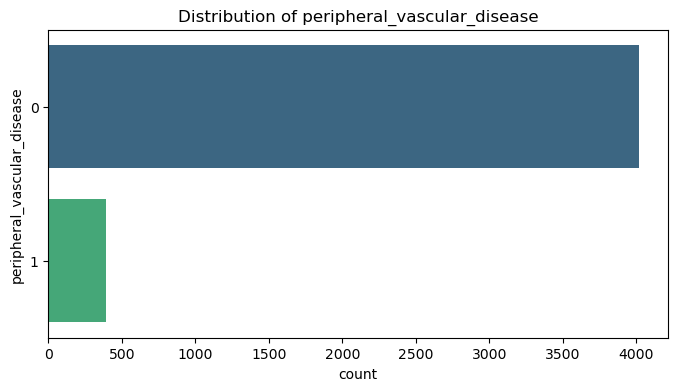

<Figure size 800x400 with 0 Axes>

<AxesSubplot:xlabel='count', ylabel='cerebrovascular_disease'>

Text(0.5, 1.0, 'Distribution of cerebrovascular_disease')

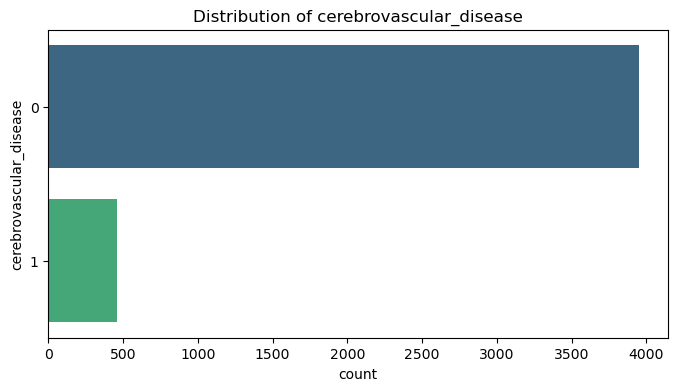

<Figure size 800x400 with 0 Axes>

<AxesSubplot:xlabel='count', ylabel='dementia'>

Text(0.5, 1.0, 'Distribution of dementia')

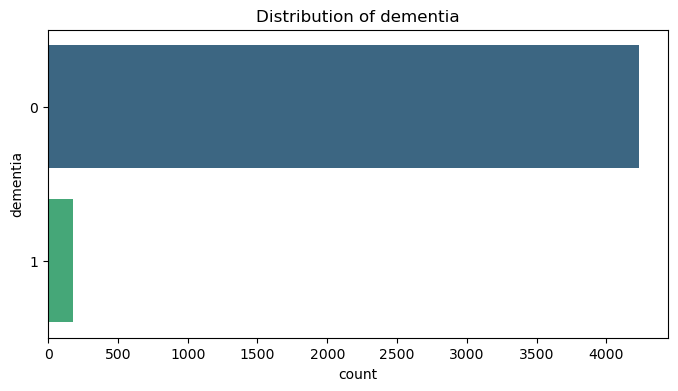

<Figure size 800x400 with 0 Axes>

<AxesSubplot:xlabel='count', ylabel='chronic_pulmonary_disease'>

Text(0.5, 1.0, 'Distribution of chronic_pulmonary_disease')

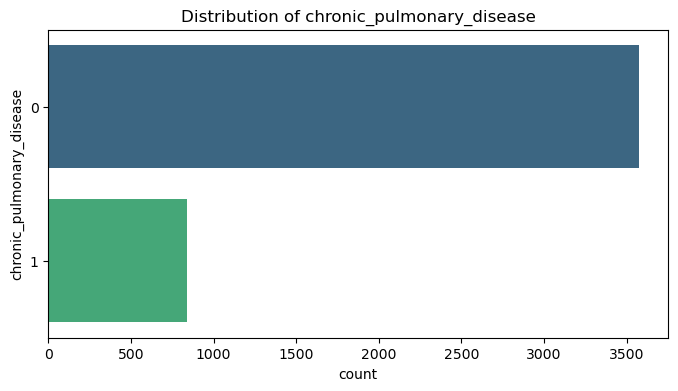

<Figure size 800x400 with 0 Axes>

<AxesSubplot:xlabel='count', ylabel='rheumatic_disease'>

Text(0.5, 1.0, 'Distribution of rheumatic_disease')

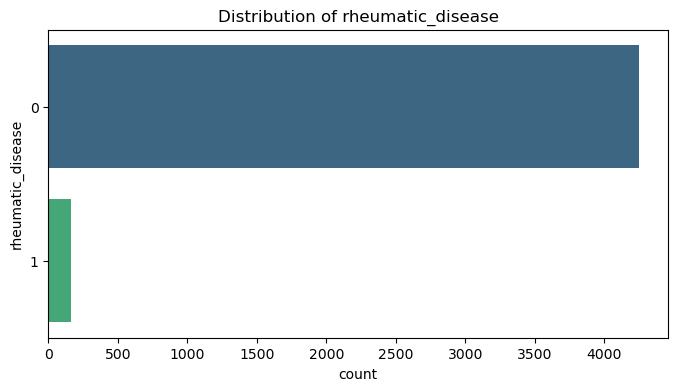

<Figure size 800x400 with 0 Axes>

<AxesSubplot:xlabel='count', ylabel='peptic_ulcer_disease'>

Text(0.5, 1.0, 'Distribution of peptic_ulcer_disease')

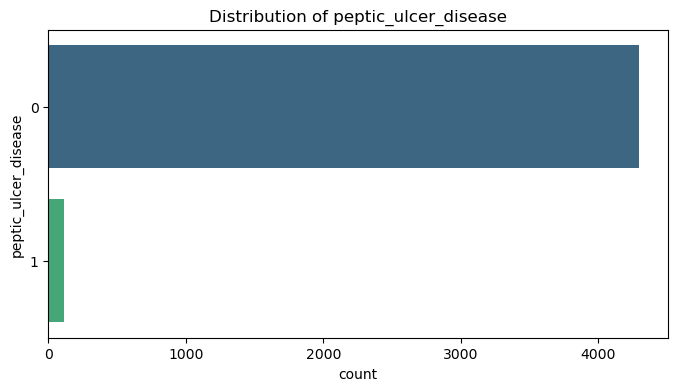

<Figure size 800x400 with 0 Axes>

<AxesSubplot:xlabel='count', ylabel='mild_liver_disease'>

Text(0.5, 1.0, 'Distribution of mild_liver_disease')

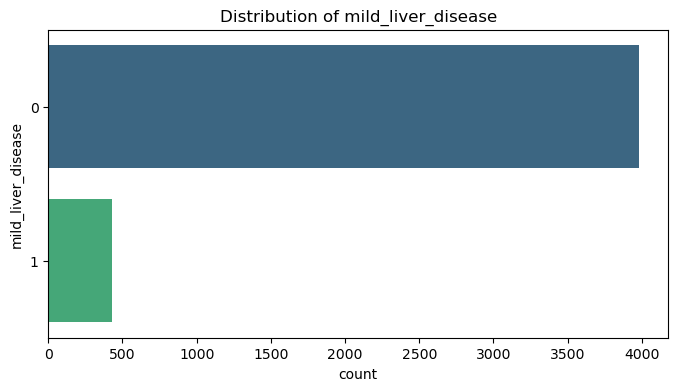

<Figure size 800x400 with 0 Axes>

<AxesSubplot:xlabel='count', ylabel='diabetes_without_cc'>

Text(0.5, 1.0, 'Distribution of diabetes_without_cc')

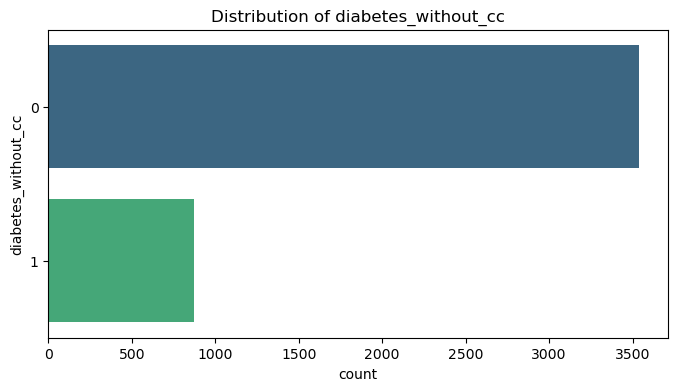

<Figure size 800x400 with 0 Axes>

<AxesSubplot:xlabel='count', ylabel='diabetes_with_cc'>

Text(0.5, 1.0, 'Distribution of diabetes_with_cc')

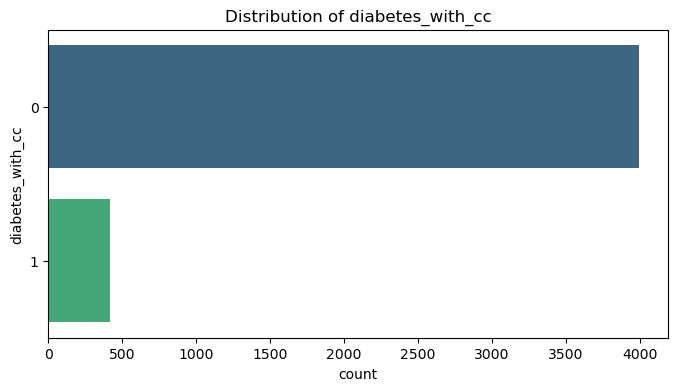

<Figure size 800x400 with 0 Axes>

<AxesSubplot:xlabel='count', ylabel='paraplegia'>

Text(0.5, 1.0, 'Distribution of paraplegia')

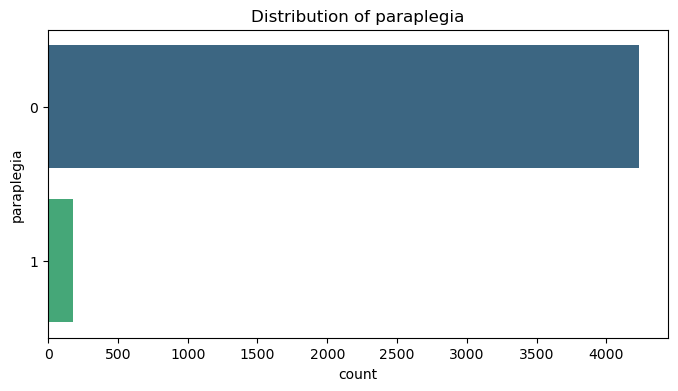

<Figure size 800x400 with 0 Axes>

<AxesSubplot:xlabel='count', ylabel='renal_disease'>

Text(0.5, 1.0, 'Distribution of renal_disease')

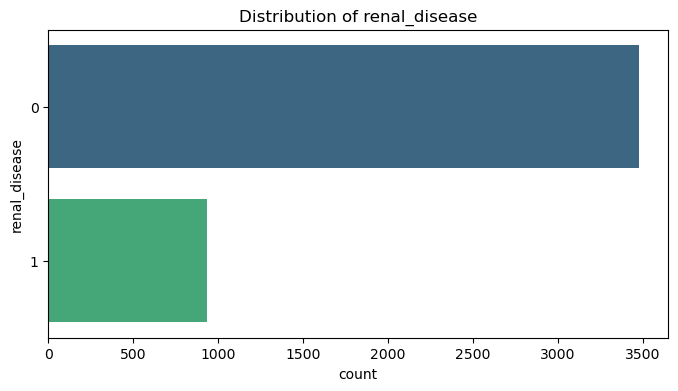

<Figure size 800x400 with 0 Axes>

<AxesSubplot:xlabel='count', ylabel='malignant_cancer'>

Text(0.5, 1.0, 'Distribution of malignant_cancer')

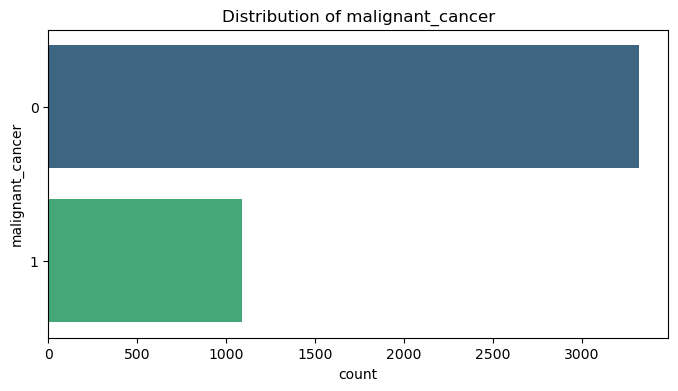

<Figure size 800x400 with 0 Axes>

<AxesSubplot:xlabel='count', ylabel='severe_liver_disease'>

Text(0.5, 1.0, 'Distribution of severe_liver_disease')

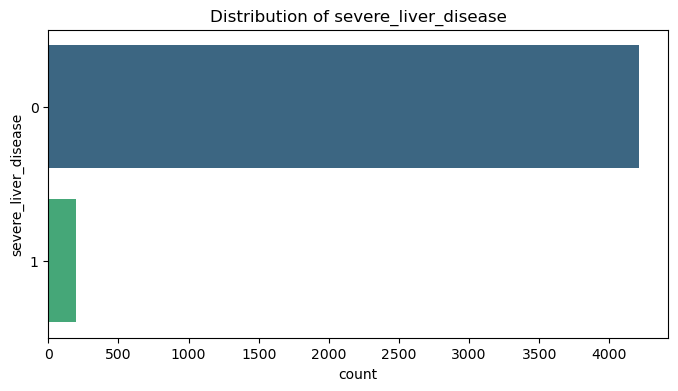

<Figure size 800x400 with 0 Axes>

<AxesSubplot:xlabel='count', ylabel='metastatic_solid_tumor'>

Text(0.5, 1.0, 'Distribution of metastatic_solid_tumor')

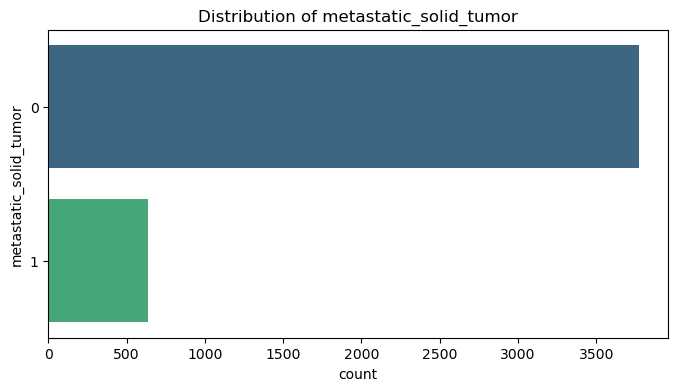

<Figure size 800x400 with 0 Axes>

<AxesSubplot:xlabel='count', ylabel='aids'>

Text(0.5, 1.0, 'Distribution of aids')

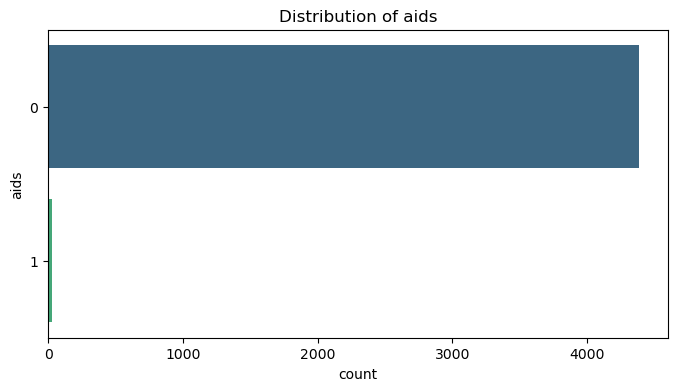

<Figure size 800x400 with 0 Axes>

<AxesSubplot:xlabel='count', ylabel='had_ddimer'>

Text(0.5, 1.0, 'Distribution of had_ddimer')

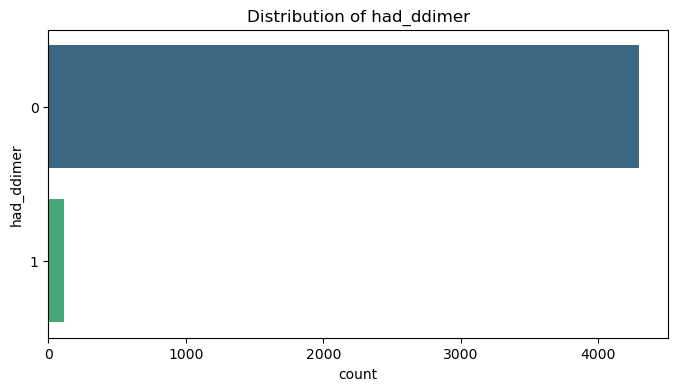

<Figure size 800x400 with 0 Axes>

<AxesSubplot:xlabel='count', ylabel='had_o2_sat'>

Text(0.5, 1.0, 'Distribution of had_o2_sat')

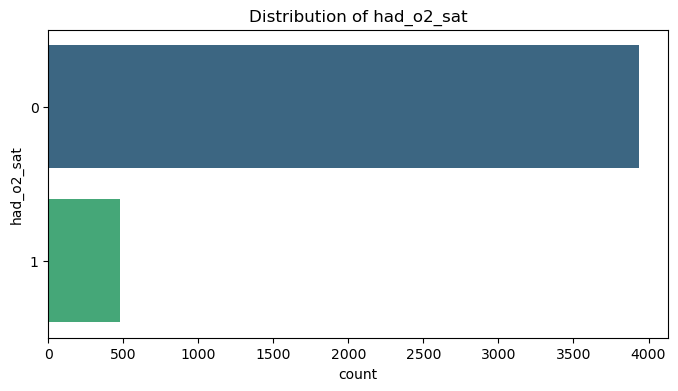

<Figure size 800x400 with 0 Axes>

<AxesSubplot:xlabel='count', ylabel='ac_flag'>

Text(0.5, 1.0, 'Distribution of ac_flag')

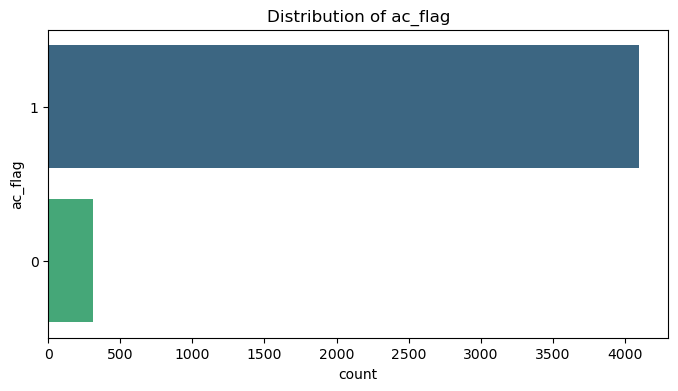

<Figure size 800x400 with 0 Axes>

<AxesSubplot:xlabel='count', ylabel='lytics_flag'>

Text(0.5, 1.0, 'Distribution of lytics_flag')

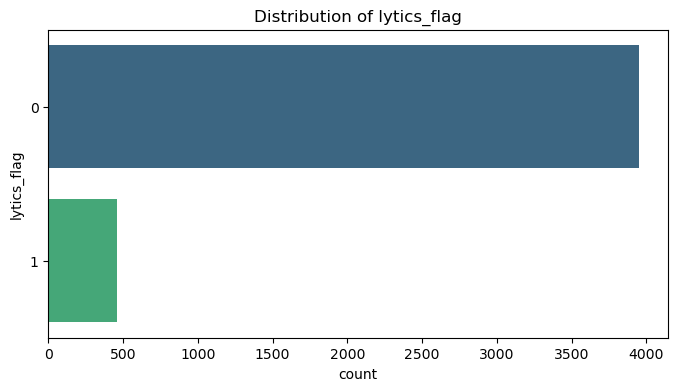

<Figure size 800x400 with 0 Axes>

<AxesSubplot:xlabel='count', ylabel='mt_flag'>

Text(0.5, 1.0, 'Distribution of mt_flag')

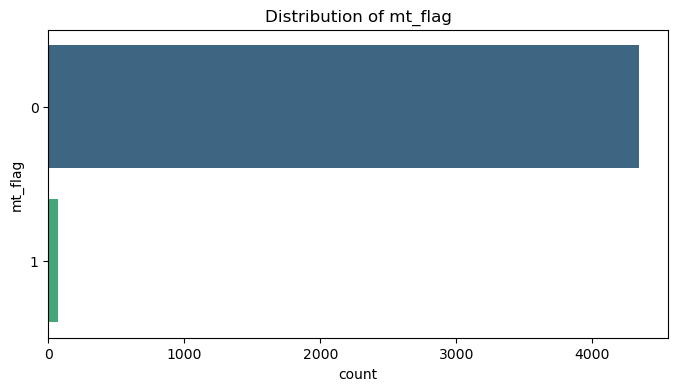

<Figure size 800x400 with 0 Axes>

<AxesSubplot:xlabel='count', ylabel='us_cdt_flag'>

Text(0.5, 1.0, 'Distribution of us_cdt_flag')

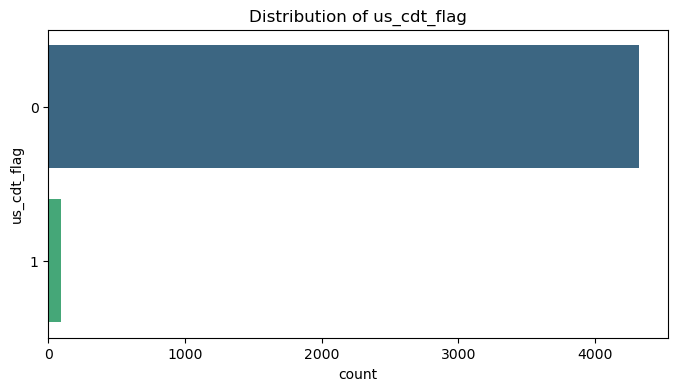

In [146]:
# Identify categorical columns (object + binary)
object_cols = df.select_dtypes(include = ['object']).columns.tolist()  # Object-type categorical columns

# Add binary columns
binary_cols = [
    "had_dvt_as_pri_diagnosis", "had_icu_stay", "hx_ac", "hx_dvt", "hx_pe", "hx_vte",
    "pe_outcome", "myocardial_infarct", "congestive_heart_failure", "peripheral_vascular_disease",
    "cerebrovascular_disease", "dementia", "chronic_pulmonary_disease", "rheumatic_disease",
    "peptic_ulcer_disease", "mild_liver_disease", "diabetes_without_cc", "diabetes_with_cc",
    "paraplegia", "renal_disease", "malignant_cancer", "severe_liver_disease",
    "metastatic_solid_tumor", "aids", "had_ddimer", "had_o2_sat", "ac_flag", "lytics_flag",
    "mt_flag", "us_cdt_flag"
]

# Combine categorical and binary columns
cat_cols = object_cols + binary_cols

# Plot count distributions for each categorical column
for col in cat_cols:
    plt.figure(figsize = (8, 4))
    sns.countplot(y = df[col], order = df[col].value_counts().index, palette="viridis")
    plt.title(f"Distribution of {col}")
    plt.show()

Findings: 
- DVT patients seem to have a higher risk of PE: the proportion of PE cases among patients with DVT as their primary diagnosis is higher than their overall representation in the dataset
- PE occurs in non-DVT primary diagnosis patients too: PE cases arise from patients where DVT was not the primary concern at admission, suggesting that clinicians should monitor for PE even in patients without a primary DVT diagnosis, as a substantial portion of PE cases are coming from this group

In [147]:
# Calculate percentage of patients who didn't and did have DVT as their primary diagnosis
df['had_dvt_as_pri_diagnosis'].value_counts(normalize = True) * 100

0   75.78
1   24.22
Name: had_dvt_as_pri_diagnosis, dtype: float64

In [148]:
# See breakdown of PE outcome by whether DVT was primary diagnosis or not

# Filter for only patients who had PE (pe_outcome = 1)
total_pe_cases = df['pe_outcome'].sum() # Total number of PE cases across all categories

# Calculate the total count of PE outcomes by has DVT as primary diagnosis flag
pe_counts = df.groupby('had_dvt_as_pri_diagnosis')['pe_outcome'].sum()

# Compute percentage of PE cases relative to the total number of PE cases
pe_percentage = (pe_counts / total_pe_cases) * 100

# Display results
print(pe_percentage)

had_dvt_as_pri_diagnosis
0   64.98
1   35.02
Name: pe_outcome, dtype: float64


#### Bivariate Analysis

##### Correlation Heatmap

Findings:
- Number of DVT admissions is strongly correlated (0.86) with the number of DVT diagnoses --> drop one (num_dvt_admissions is a more meaningful variable because it reflects separate hospital admissions where DVT was diagnosed, rather than just the total number of diagnoses, which could be redundant within a single admission)
- Age is moderately corelated (0.60) with Charlson Comorbidity Index score

<Figure size 1000x600 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'Correlation Heatmap')

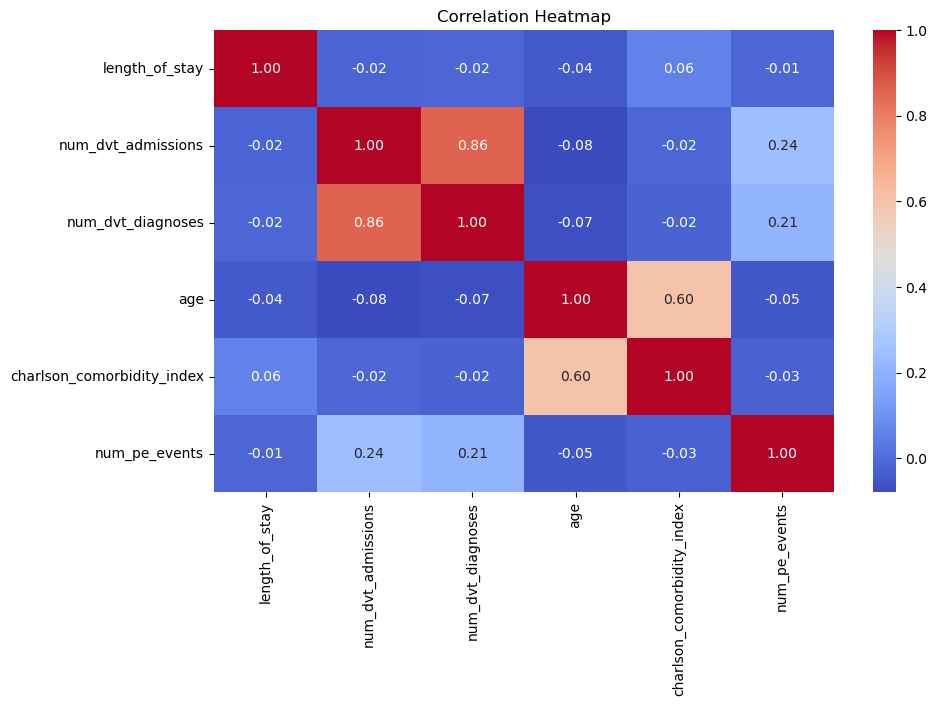

In [149]:
# Compute correlation matrix  for numeric variables
corr_matrix = df[num_cols].corr()

plt.figure(figsize = (10, 6))
sns.heatmap(corr_matrix, annot = True, cmap = "coolwarm", fmt = ".2f")
plt.title("Correlation Heatmap")
plt.show()

##### VIF

To formally assess multicollinearity among numeric features, the Variance Inflation Factor (VIF) was calculated. VIF measures how much a predictor variable is correlated with other independent variables in the dataset, helping identify redundancy and potential issues in the model.

Initially, num_dvt_admissions and num_dvt_diagnoses exhibited high collinearity (VIF = 11.21 and 8.70, respectively), indicating substantial overlap in the information they provide. Given that num_dvt_diagnoses had a slightly weaker correlation with the target variable (pe_outcome) compared to num_dvt_admissions, it was removed to reduce redundancy and improve model stability.

After removing num_dvt_diagnoses, VIF was recomputed, showing a significant reduction in multicollinearity. num_dvt_admissions dropped from 11.21 to 2.78, confirming that the removal successfully mitigated excessive collinearity. The highest remaining VIF is now 7.13 for age, so future modeling can test performance with inclusion/exclusion of this field.

In [150]:
# Create dataframe only including numeric fields

numeric_features = df[num_cols]
# Compute VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = numeric_features.columns
vif_data["VIF"] = [variance_inflation_factor(numeric_features.values, i) for i in range(numeric_features.shape[1])]

# Display results
print(vif_data.sort_values(by = "VIF", ascending=False))

                      Feature   VIF
1          num_dvt_admissions 11.21
2           num_dvt_diagnoses  8.70
3                         age  7.15
4  charlson_comorbidity_index  4.99
0              length_of_stay  1.48
5               num_pe_events  1.10


In [151]:
# Point-Biserial correlation
from scipy.stats import pointbiserialr

# Calculate Point-Biserial Correlation
correlation, p_value = pointbiserialr(df["num_dvt_diagnoses"], df["pe_outcome"])

print(f"Point-Biserial Correlation: {correlation:.3f}")
print(f"P-Value: {p_value:.3f}")

Point-Biserial Correlation: 0.192
P-Value: 0.000


In [152]:
# Point-Biserial correlation
from scipy.stats import pointbiserialr

# Calculate Point-Biserial Correlation
correlation, p_value = pointbiserialr(df["num_dvt_admissions"], df["pe_outcome"])

print(f"Point-Biserial Correlation: {correlation:.3f}")
print(f"P-Value: {p_value:.3f}")

Point-Biserial Correlation: 0.209
P-Value: 0.000


In [153]:
df_reduced = df.drop(columns=["num_dvt_diagnoses"])  # Drop the column

# Recalculate numeric features AFTER dropping to avoid KeyError
num_cols = ['length_of_stay', 'num_dvt_admissions', 'age', 'charlson_comorbidity_index', 'num_pe_events']
numeric_features_reduced = df[num_cols]  # Ensure this is a DataFrame, not a list

# Compute VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data_reduced = pd.DataFrame()
vif_data_reduced["Feature"] = numeric_features_reduced.columns
vif_data_reduced["VIF"] = [variance_inflation_factor(numeric_features_reduced.values, i) for i in range(numeric_features_reduced.shape[1])]

print(vif_data_reduced.sort_values(by="VIF", ascending=False))

                      Feature  VIF
2                         age 7.13
3  charlson_comorbidity_index 4.99
1          num_dvt_admissions 2.78
0              length_of_stay 1.48
4               num_pe_events 1.10


##### Cramer's V

In [154]:
# Source:
# https://stackoverflow.com/questions/46498455/categorical-features-correlation/46498792#46498792
def cramers_v(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

In [155]:
# Source:
# https://stackoverflow.com/questions/51859894/how-to-plot-a-cramer-s-v-heatmap-for-categorical-features
def plot_cramers_v_heatmap(df, cols, figsize = (20, 15), fontsize = 12):
    corrM = np.zeros((len(cols),len(cols)))

    for col1, col2 in itertools.combinations(cols, 2):
        idx1, idx2 = cols.index(col1), cols.index(col2)
        corrM[idx1, idx2] = cramers_v(pd.crosstab(df[col1], df[col2]).values)
        corrM[idx2, idx1] = corrM[idx1, idx2]

    corr = pd.DataFrame(corrM, index=cols, columns=cols)
    fig, ax = plt.subplots(figsize = figsize)
    ax = sns.heatmap(corr, annot=True, cmap = 'coolwarm', ax = ax); ax.set_title("Cramer V Correlation between Variables");

C:\Users\alexm\AppData\Local\Temp\ipykernel_19912\3242525159.py:15: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
C:\Users\alexm\AppData\Local\Temp\ipykernel_19912\3242525159.py:15: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
C:\Users\alexm\AppData\Local\Temp\ipykernel_19912\3242525159.py:15: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
C:\Users\alexm\AppData\Local\Temp\ipykernel_19912\3242525159.py:15: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
C:\Users\alexm\AppData\Local\Temp\ipykernel_19912\3242525159.py:15: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
C:\Users\alexm\AppData\Local\Temp\ipykernel_19912\3242525159.py:15: RuntimeWarning: invali

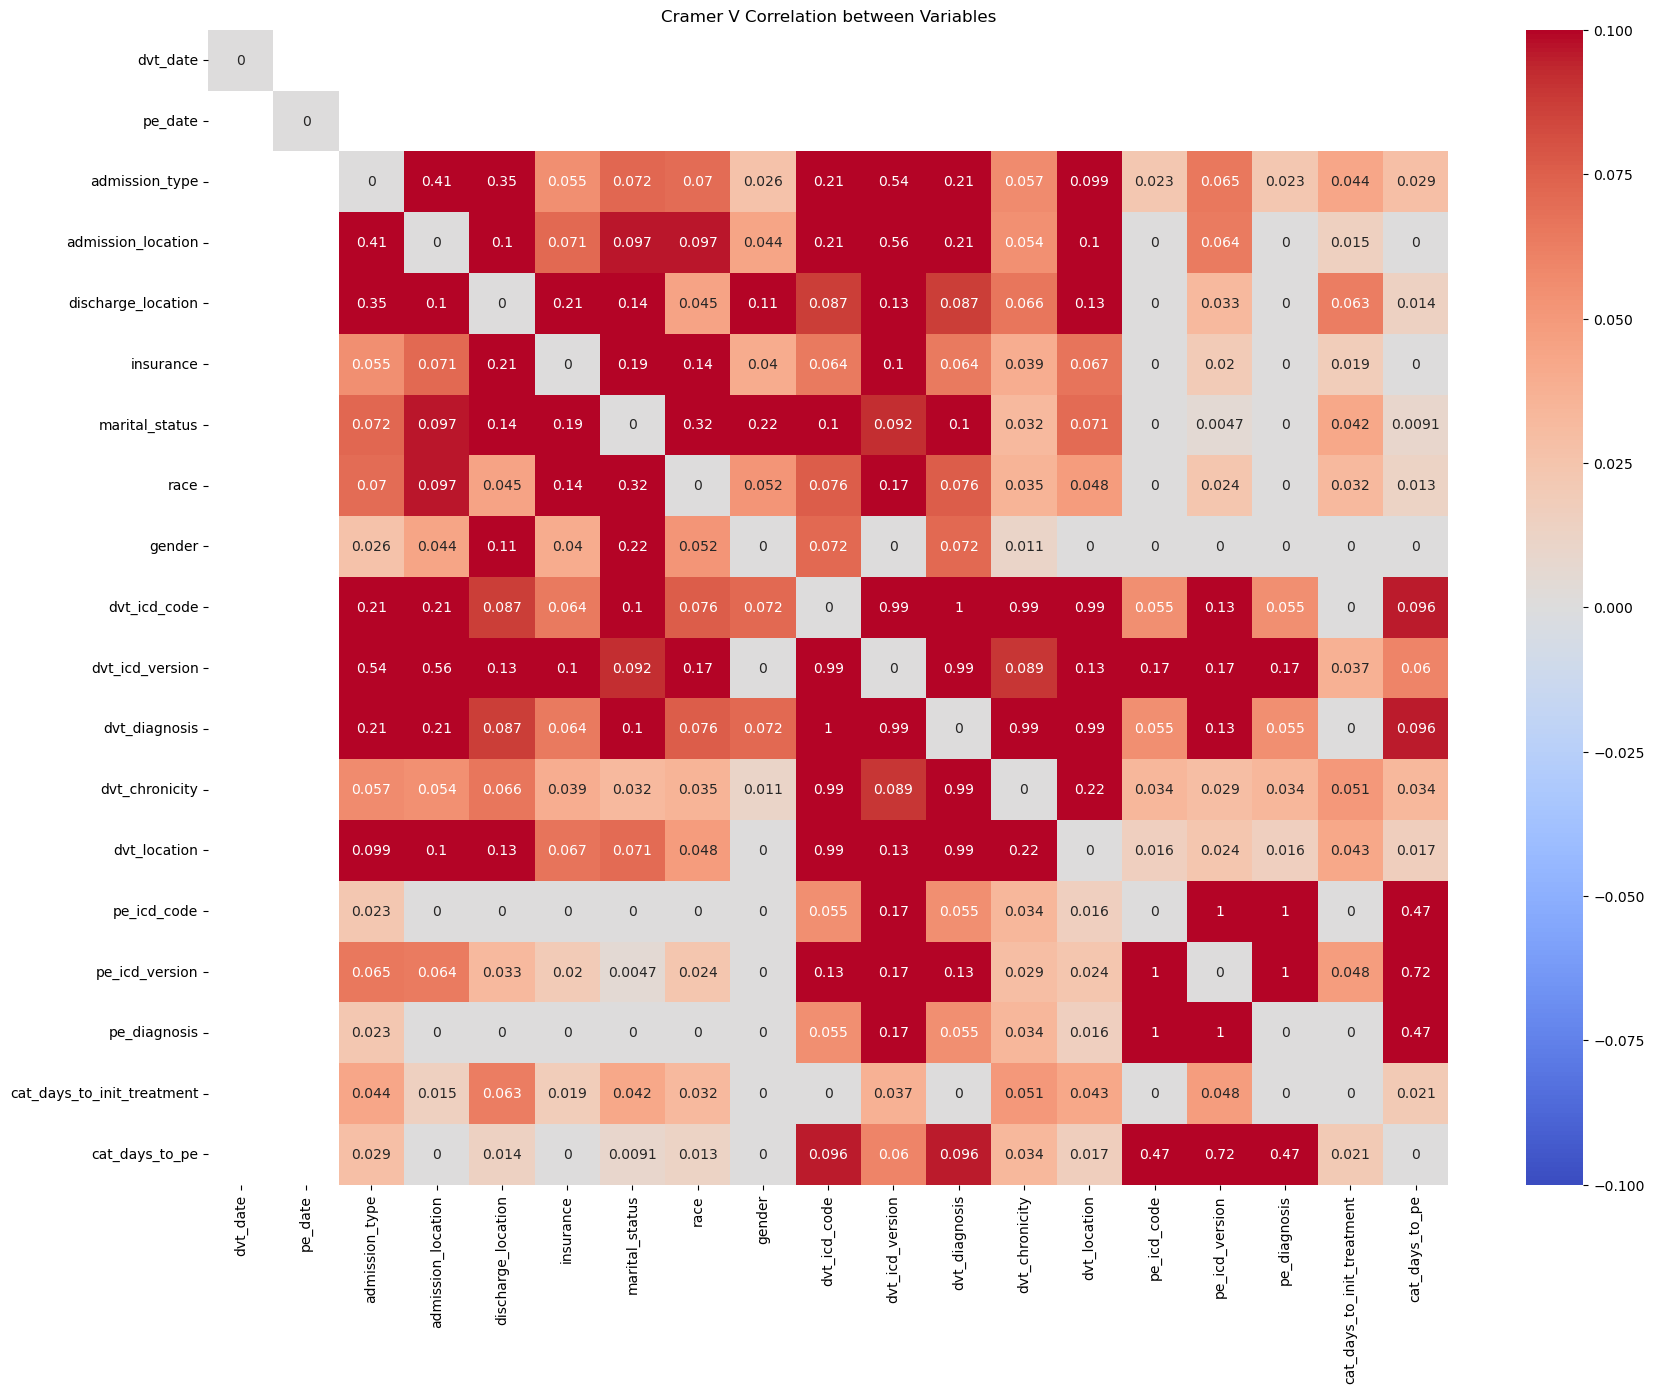

In [156]:
plot_cramers_v_heatmap(df, object_cols)

In [157]:
# These are the only categorical features that would be considered for modeling
object_cols_reduced = ['admission_type',
 'admission_location',
 'discharge_location',
 'insurance',
 'marital_status',
 'race',
 'gender',
 'dvt_chronicity',
 'dvt_location',
 'cat_days_to_init_treatment',
 ]

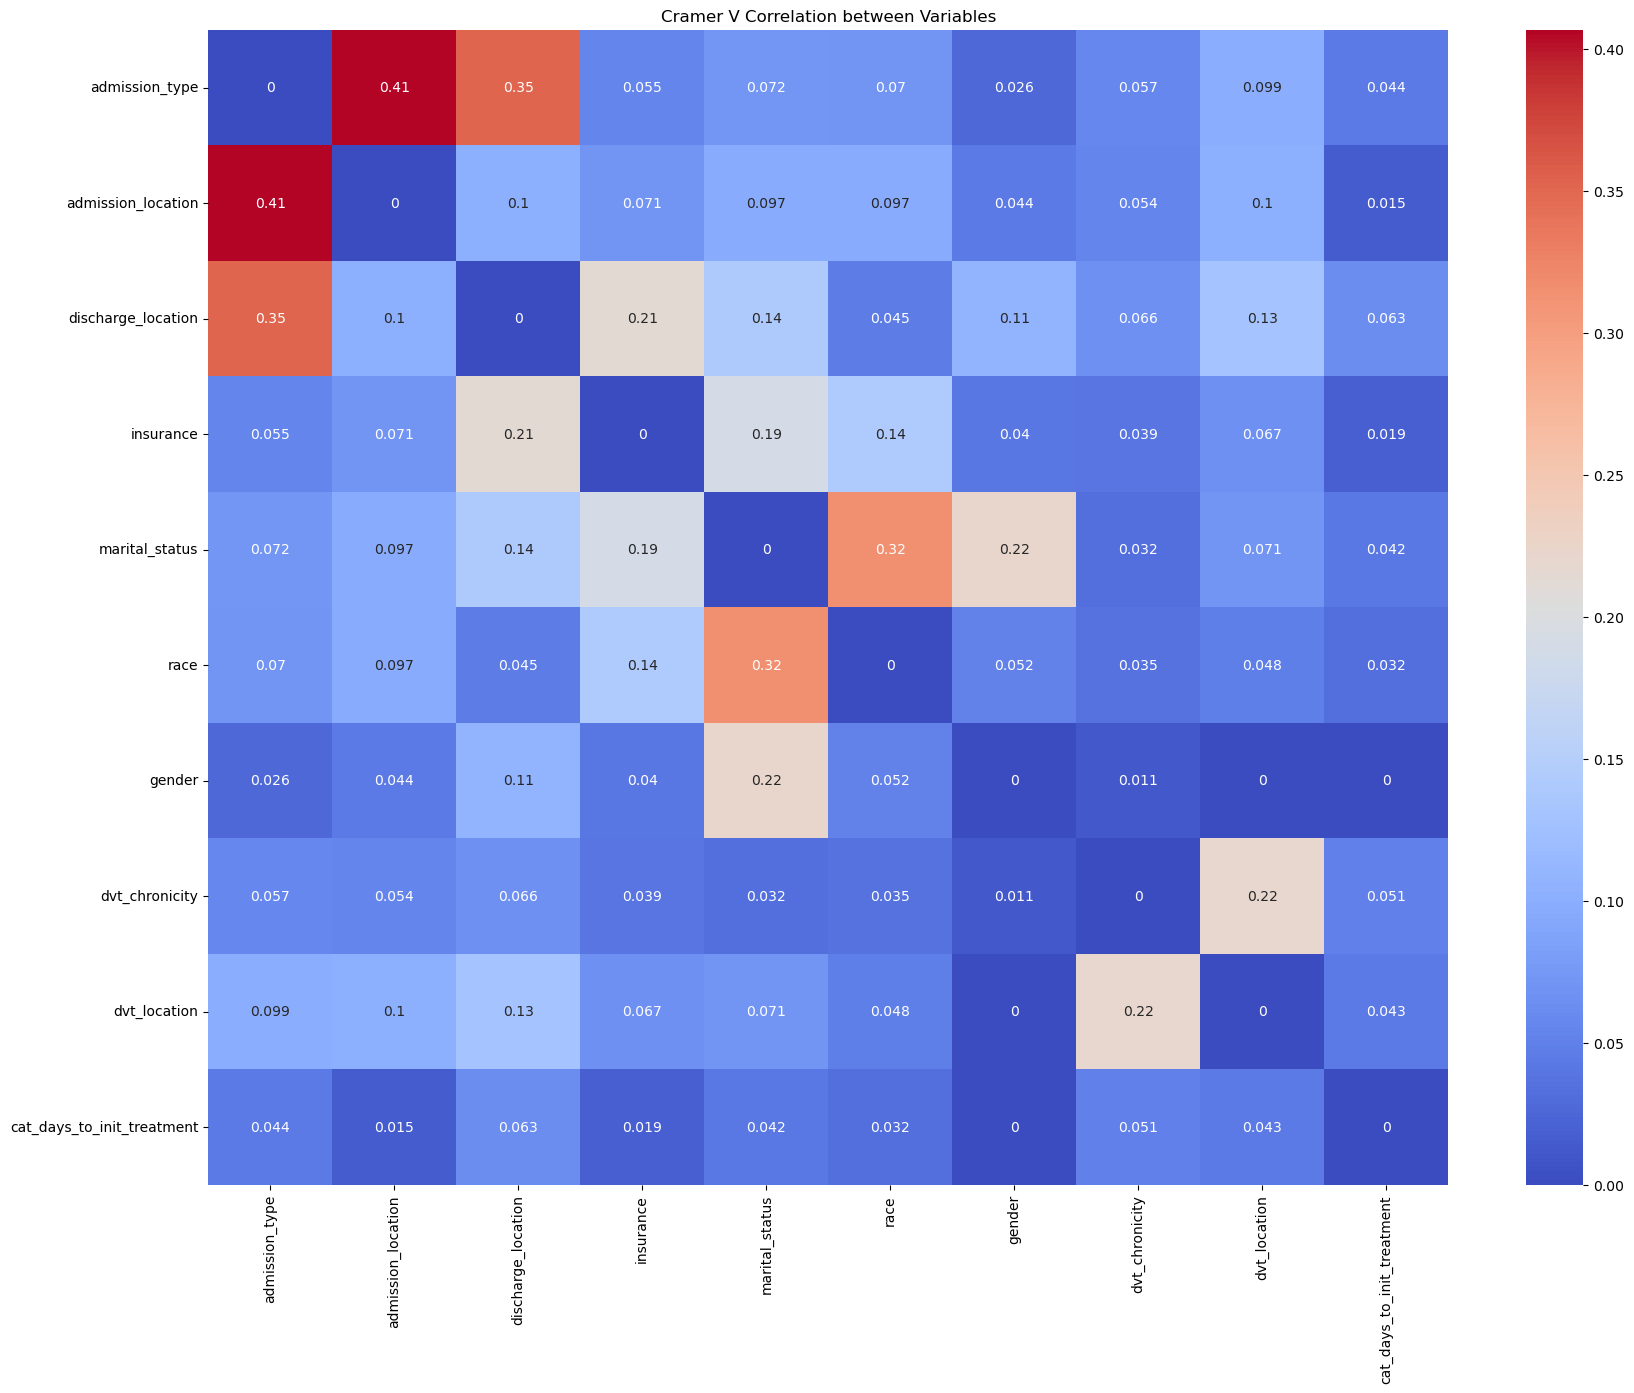

In [158]:
plot_cramers_v_heatmap(df, object_cols_reduced) # No multicollinearity concern

##### VIF
To address multicollinearity among binary features, Variance Inflation Factor (VIF) was used to identify redundant predictors. Initially, hx_vte and hx_dvt exhibited severe multicollinearity (VIF = 31.05 and 27.51, respectively), suggesting strong redundancy between the two. To resolve this, hx_dvt was removed, as its correlation with the target variable (pe_outcome) was slightly weaker than hx_vte.

After dropping hx_dvt, VIF was recalculated, revealing a significant reduction in multicollinearity. The VIF for hx_vte dropped from 31.05 to 2.87, confirming that removing hx_dvt successfully mitigated redundancy. No remaining features have VIF > 5, indicating that multicollinearity has been effectively addressed, ensuring model stability and interpretability.

In [159]:
# Create dataframe only including binary fields
binary_features = df[binary_cols]

# Compute VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = binary_features.columns
vif_data["VIF"] = [variance_inflation_factor(binary_features.values, i) for i in range(binary_features.shape[1])]

# Display results
print(vif_data.sort_values(by = "VIF", ascending = False)) 

                        Feature   VIF
5                        hx_vte 31.05
3                        hx_dvt 27.51
26                      ac_flag  4.90
2                         hx_ac  2.97
1                  had_icu_stay  2.67
20             malignant_cancer  1.74
4                         hx_pe  1.68
19                renal_disease  1.56
22       metastatic_solid_tumor  1.52
15           mild_liver_disease  1.48
8      congestive_heart_failure  1.47
29                  us_cdt_flag  1.45
0      had_dvt_as_pri_diagnosis  1.44
21         severe_liver_disease  1.40
27                  lytics_flag  1.35
28                      mt_flag  1.33
17             diabetes_with_cc  1.32
25                   had_o2_sat  1.31
12    chronic_pulmonary_disease  1.28
16          diabetes_without_cc  1.28
10      cerebrovascular_disease  1.26
7            myocardial_infarct  1.19
6                    pe_outcome  1.17
9   peripheral_vascular_disease  1.15
18                   paraplegia  1.14
11          

In [160]:
df[["hx_vte", "hx_dvt"]].corr() 

,hx_vte,hx_dvt
hx_vte,1.00,0.96
hx_dvt,0.96,1.00


In [161]:
# Compute correlation with pe_outcome
corr_hx_vte, pval_hx_vte = pointbiserialr(df["hx_vte"], df["pe_outcome"])
corr_hx_dvt, pval_hx_dvt = pointbiserialr(df["hx_dvt"], df["pe_outcome"])

# Print results
print(f"Point-Biserial Correlation of hx_vte with pe_outcome: {corr_hx_vte:.3f}, p-value: {pval_hx_vte:.3f}")
print(f"Point-Biserial Correlation of hx_dvt with pe_outcome: {corr_hx_dvt:.3f}, p-value: {pval_hx_dvt:.3f}")

Point-Biserial Correlation of hx_vte with pe_outcome: 0.150, p-value: 0.000
Point-Biserial Correlation of hx_dvt with pe_outcome: 0.147, p-value: 0.000


In [162]:
# Drop hx_dvt
df_reduced = df.drop(columns = ["hx_dvt"])

binary_cols_reduced = [
    "had_dvt_as_pri_diagnosis", "had_icu_stay", "hx_ac", "hx_pe", "hx_vte",
    "pe_outcome", "myocardial_infarct", "congestive_heart_failure", "peripheral_vascular_disease",
    "cerebrovascular_disease", "dementia", "chronic_pulmonary_disease", "rheumatic_disease",
    "peptic_ulcer_disease", "mild_liver_disease", "diabetes_without_cc", "diabetes_with_cc",
    "paraplegia", "renal_disease", "malignant_cancer", "severe_liver_disease",
    "metastatic_solid_tumor", "aids", "had_ddimer", "had_o2_sat", "ac_flag", "lytics_flag",
    "mt_flag", "us_cdt_flag"
]

# Select only numeric features again
binary_features_reduced = df[binary_cols_reduced]

# Compute VIF
vif_data_reduced = pd.DataFrame()
vif_data_reduced["Feature"] = binary_features_reduced.columns
vif_data_reduced["VIF"] = [variance_inflation_factor(binary_features_reduced.values, i) 
                           for i in range(binary_features_reduced.shape[1])]

# Display results
print(vif_data_reduced.sort_values(by = "VIF", ascending = False))

                        Feature  VIF
25                      ac_flag 4.90
2                         hx_ac 2.97
4                        hx_vte 2.87
1                  had_icu_stay 2.67
19             malignant_cancer 1.74
18                renal_disease 1.56
21       metastatic_solid_tumor 1.52
14           mild_liver_disease 1.48
7      congestive_heart_failure 1.47
28                  us_cdt_flag 1.45
0      had_dvt_as_pri_diagnosis 1.44
3                         hx_pe 1.42
20         severe_liver_disease 1.40
26                  lytics_flag 1.35
27                      mt_flag 1.33
16             diabetes_with_cc 1.32
24                   had_o2_sat 1.31
11    chronic_pulmonary_disease 1.28
15          diabetes_without_cc 1.28
9       cerebrovascular_disease 1.26
6            myocardial_infarct 1.19
5                    pe_outcome 1.16
8   peripheral_vascular_disease 1.15
17                   paraplegia 1.14
10                     dementia 1.07
12            rheumatic_disease 1.05
1

### Feature Engineering

In [163]:
# Create a single "treatment" field

# Define treatment labels
treatment_labels = {
    "ac_flag": "AC",
    "lytics_flag": "Lytics",
    "mt_flag": "MT",
    "us_cdt_flag": "CDT"
}

# Create treatment column by joining multiple active treatments
df["treatment"] = df.apply(lambda row: ", ".join([name for col, name in treatment_labels.items() if row[col] == 1]), axis = 1)

# See unique categories
df['treatment'].value_counts()

AC                     3604
AC, Lytics              375
                        309
AC, Lytics, CDT          40
AC, Lytics, MT, CDT      34
AC, MT                   18
AC, CDT                  12
AC, Lytics, MT           10
AC, MT, CDT               4
MT                        3
Lytics                    1
Name: treatment, dtype: int64

In [164]:
# Consolidate treatment categories

# Define function to consolidate treatment categories
def consolidate_treatment(treatment):
    if pd.isna(treatment) or treatment.strip() == "":
        return "No Treatment"
    elif treatment == "AC":
        return "AC Only"
    elif "MT" in treatment and "CDT" in treatment:
        return "Multiple Interventions"
    elif "Lytics" in treatment and "MT" not in treatment and "CDT" not in treatment:
        return "Lytics"
    elif "MT" in treatment and "CDT" not in treatment:
        return "MT"
    elif "CDT" in treatment and "MT" not in treatment:
        return "CDT"
    else:
        return "Other"

# Apply the function to create a new consolidated column
df["treatment_grouped"] = df["treatment"].apply(consolidate_treatment)

# Check value distribution
df["treatment_grouped"].value_counts()

# Check value distribution (percentages)
df["treatment_grouped"].value_counts(normalize = True) * 100

AC Only                   3604
Lytics                     376
No Treatment               309
CDT                         52
Multiple Interventions      38
MT                          31
Name: treatment_grouped, dtype: int64

AC Only                  81.72
Lytics                    8.53
No Treatment              7.01
CDT                       1.18
Multiple Interventions    0.86
MT                        0.70
Name: treatment_grouped, dtype: float64

There is a match between how many "No Treatment" values there are in the treatment_grouped field (309) versus in the cat_days_to_init_treatment field (309), which is good.

In [165]:
# Check value distribution of cat_days_to_init_treatment
df["cat_days_to_init_treatment"].value_counts()

Same day            3275
1-3 days             717
No Treatment         309
4-7 days              45
Unknown               42
More than 7 days      22
Name: cat_days_to_init_treatment, dtype: int64

In [166]:
# Filter for only patients who had PE (pe_outcome = 1)
total_pe_cases = df['pe_outcome'].sum() # Total number of PE cases across all categories

# Calculate the total count of PE outcomes in each DVT treatment category
pe_counts = df.groupby('treatment_grouped')['pe_outcome'].sum()

# Compute percentage of PE cases relative to the total number of PE cases
pe_percentage = (pe_counts / total_pe_cases) * 100

# Display results
print(pe_percentage)

treatment_grouped
AC Only                  82.95
CDT                       2.30
Lytics                   10.14
MT                        0.46
Multiple Interventions    0.46
No Treatment              3.69
Name: pe_outcome, dtype: float64


In [167]:
# Count total patients in each treatment group
total_patients_per_group = df['treatment_grouped'].value_counts()

# Compute PE Rate per Treatment Group
pe_rate = (pe_counts / total_patients_per_group) * 100

# Convert to DataFrame for better readability
pe_rate_df = pe_rate.reset_index()
pe_rate_df.columns = ['Treatment Group', 'PE Rate (%)']

pe_rate_df

,Treatment Group,PE Rate (%)
0,AC Only,4.99
1,CDT,9.62
2,Lytics,5.85
3,MT,3.23
4,Multiple Interventions,2.63
5,No Treatment,2.59


Findings:

No Treatment Patients Were Not Dramatically Healthier
- Charlson Comorbidity Index (4.97) was similar to AC Only (5.04) → Similar chronic illness burden.
- Length of Stay (10.83 days) was almost the same as AC Only (10.30 days) → No major difference.
- ICU Admission Rate (51%) was slightly lower than AC Only (54%), but still significant.
- Fewer prior DVTs and PEs compared to treated groups, suggesting lower baseline clotting risk.

CDT and Lytics Patients Were Likely Sicker
- Lytics group had the highest ICU admission rate (76%) and longest hospital stay (30.66 days) → Suggesting more critical illness.
- CDT group had the second-highest ICU rate (73%) and longer stays (14.17 days).
- Higher prior PE history (CDT: 21%, Lytics: 12%), meaning they had a greater risk of recurrent PE.

Multiple Interventions Patients Were the Healthiest
- Lowest Charlson Comorbidity Index (1.21) → Fewer chronic conditions.
- Shortest hospital stay (6.82 days) → Indicating less severe illness or better response to treatment.
- Youngest average age (44.18 years) → Much younger than other groups.
- Lower ICU admission rate (39%), reinforcing their lower severity.

PE Event Rate Was Very Low in All Groups
- Very few patients had multiple PE events, regardless of treatment type.
- No Treatment patients had an extremely low prior PE history (4%), reinforcing that they may have been at lower risk to begin with.

In [168]:
# Define key clinical severity metrics
severity_metrics = [
    "charlson_comorbidity_index",
    "length_of_stay",
    "had_icu_stay",
    "age",
    "had_dvt_as_pri_diagnosis",
    "num_dvt_admissions",
    "num_pe_events",
    "hx_dvt",
    "hx_pe",
    "hx_vte"
]

# Compute mean values of severity metrics per treatment group
severity_comparison = df.groupby("treatment_grouped")[severity_metrics].mean()

severity_comparison

,charlson_comorbidity_index,length_of_stay,had_icu_stay,age,had_dvt_as_pri_diagnosis,num_dvt_admissions,num_pe_events,hx_dvt,hx_pe,hx_vte
treatment_grouped,,,,,,,,,,
AC Only,5.04,10.30,0.54,64.60,0.25,1.37,0.07,0.51,0.13,0.53
CDT,3.23,14.17,0.73,53.94,0.37,1.69,0.23,0.46,0.21,0.56
Lytics,4.59,30.66,0.76,59.35,0.05,1.31,0.07,0.47,0.12,0.48
MT,3.68,14.97,0.65,54.55,0.39,1.32,0.03,0.45,0.16,0.48
Multiple Interventions,1.21,6.82,0.39,44.18,0.87,1.37,0.03,0.34,0.13,0.34
No Treatment,4.97,10.83,0.51,63.22,0.24,1.17,0.03,0.34,0.04,0.36


In [169]:
# Consolidate race field

# Define mapping dictionary
race_mapping = {
    "BLACK/AFRICAN AMERICAN": "Black",
    "BLACK/CARIBBEAN ISLAND": "Black",
    "BLACK/CAPE VERDEAN": "Black",
    "BLACK/AFRICAN": "Black",
    
    "WHITE": "White",
    "WHITE - OTHER EUROPEAN": "White",
    "WHITE - EASTERN EUROPEAN": "White",
    "WHITE - RUSSIAN": "White",
    "WHITE - BRAZILIAN": "White",

    "ASIAN": "Asian",
    "ASIAN - CHINESE": "Asian",
    "ASIAN - KOREAN": "Asian",
    "ASIAN - SOUTH EAST ASIAN": "Asian",
    "ASIAN - ASIAN INDIAN": "Asian",

    "NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER": "Native Hawaiian/Pacific Islander",
    "AMERICAN INDIAN/ALASKA NATIVE": "American Indian/Alaska Native",

    "HISPANIC OR LATINO": "Hispanic/Latino",
    "HISPANIC/LATINO - CENTRAL AMERICAN": "Hispanic/Latino",
    "HISPANIC/LATINO - PUERTO RICAN": "Hispanic/Latino",
    "HISPANIC/LATINO - DOMINICAN": "Hispanic/Latino",
    "HISPANIC/LATINO - GUATEMALAN": "Hispanic/Latino",
    "HISPANIC/LATINO - COLUMBIAN": "Hispanic/Latino",
    "HISPANIC/LATINO - MEXICAN": "Hispanic/Latino",
    "HISPANIC/LATINO - CUBAN": "Hispanic/Latino",
    "HISPANIC/LATINO - SALVADORAN": "Hispanic/Latino",
    "HISPANIC/LATINO - HONDURAN": "Hispanic/Latino",
    "SOUTH AMERICAN": "Hispanic/Latino",

    "PORTUGUESE": "Portuguese",
    "MULTIPLE RACE/ETHNICITY": "Multiracial",
    
    "UNKNOWN": "Unknown",
    "UNABLE TO OBTAIN": "Unknown",
    "PATIENT DECLINED TO ANSWER": "Unknown",
    "OTHER": "Unknown"
}

# Apply mapping
df["race_grouped"] = df["race"].map(race_mapping)

# Check new category distribution
print(df["race_grouped"].value_counts())


White                               2997
Black                                690
Unknown                              371
Hispanic/Latino                      190
Asian                                116
Portuguese                            22
American Indian/Alaska Native         14
Native Hawaiian/Pacific Islander       7
Multiracial                            3
Name: race_grouped, dtype: int64


Admission/Discharge Fields:

- Drop admission_type for modeling because there is no statistically significant relationship between admission type and PE outcome
- Keep admission_location and discharge_location because there is a statistically significant relationship between these variables and PE outcome

In [170]:
# Check distribution of admission_type categories
admission_type_counts = df["admission_type"].value_counts()

# Calculate PE outcome rates for each admission type
pe_outcome_distribution = df.groupby("admission_type")["pe_outcome"].mean()

# Create a contingency table for the Chi-square test
contingency_table = pd.crosstab(df["admission_type"], df["pe_outcome"])

# Perform the Chi-square test
chi2_stat, p_value, dof, expected = ss.chi2_contingency(contingency_table)

# Display results
print("\nAdmission Type Distribution:")
print(admission_type_counts)

print("\nPE Outcome Rate by Admission Type:")
print(pe_outcome_distribution)

print("\nChi-Square Test Results:")
print(f"Chi-Square Statistic: {chi2_stat:.2f}")
print(f"P-value: {p_value:.5f}")

# Interpretation
alpha = 0.05  # Significance level
if p_value < alpha:
    print("\nThere is a statistically significant relationship between admission type and PE outcome.")
else:
    print("\nNo significant relationship found between admission type and PE outcome.")



Admission Type Distribution:
EW EMER.                       2068
OBSERVATION ADMIT              1019
URGENT                          539
EU OBSERVATION                  238
DIRECT EMER.                    236
SURGICAL SAME DAY ADMISSION     140
DIRECT OBSERVATION               82
ELECTIVE                         75
AMBULATORY OBSERVATION           13
Name: admission_type, dtype: int64

PE Outcome Rate by Admission Type:
admission_type
AMBULATORY OBSERVATION        0.08
DIRECT EMER.                  0.06
DIRECT OBSERVATION            0.05
ELECTIVE                      0.07
EU OBSERVATION                0.06
EW EMER.                      0.05
OBSERVATION ADMIT             0.04
SURGICAL SAME DAY ADMISSION   0.09
URGENT                        0.04
Name: pe_outcome, dtype: float64

Chi-Square Test Results:
Chi-Square Statistic: 9.74
P-value: 0.28389

No significant relationship found between admission type and PE outcome.


In [171]:
# Check distribution of admission_location categories
admission_location_counts = df["admission_location"].value_counts()

# Calculate PE outcome rates for each admission location
pe_outcome_distribution = df.groupby("admission_location")["pe_outcome"].mean()

# Create a contingency table for the Chi-square test
contingency_table = pd.crosstab(df["admission_location"], df["pe_outcome"])

# Perform the Chi-square test
chi2_stat, p_value, dof, expected = ss.chi2_contingency(contingency_table)

# Display results
print("\nAdmission Location Distribution:")
print(admission_location_counts)

print("\nPE Outcome Rate by Admission Location:")
print(pe_outcome_distribution)

print("\nChi-Square Test Results:")
print(f"Chi-Square Statistic: {chi2_stat:.2f}")
print(f"P-value: {p_value:.5f}")

# Interpretation
alpha = 0.05  # Significance level
if p_value < alpha:
    print("\nThere is a statistically significant relationship between admission location and PE outcome.")
else:
    print("\nNo significant relationship found between admission location and PE outcome.")


Admission Location Distribution:
EMERGENCY ROOM                            1892
TRANSFER FROM HOSPITAL                     924
PHYSICIAN REFERRAL                         891
WALK-IN/SELF REFERRAL                      364
CLINIC REFERRAL                            171
TRANSFER FROM SKILLED NURSING FACILITY      84
PROCEDURE SITE                              45
PACU                                        19
INTERNAL TRANSFER TO OR FROM PSYCH           9
AMBULATORY SURGERY TRANSFER                  7
INFORMATION NOT AVAILABLE                    4
Name: admission_location, dtype: int64

PE Outcome Rate by Admission Location:
admission_location
AMBULATORY SURGERY TRANSFER              0.00
CLINIC REFERRAL                          0.07
EMERGENCY ROOM                           0.06
INFORMATION NOT AVAILABLE                0.00
INTERNAL TRANSFER TO OR FROM PSYCH       0.00
PACU                                     0.00
PHYSICIAN REFERRAL                       0.05
PROCEDURE SITE               

In [172]:
# Check distribution of discharge_location categories
discharge_location_counts = df["discharge_location"].value_counts()

# Calculate PE outcome rates for each discharge location
pe_outcome_distribution = df.groupby("discharge_location")["pe_outcome"].mean()

# Create a contingency table for the Chi-square test
contingency_table = pd.crosstab(df["discharge_location"], df["pe_outcome"])

# Perform the Chi-square test
chi2_stat, p_value, dof, expected = ss.chi2_contingency(contingency_table)

# Display results
print("\Discharge Location Distribution:")
print(discharge_location_counts)

print("\nPE Outcome Rate by Discharge Location:")
print(pe_outcome_distribution)

print("\nChi-Square Test Results:")
print(f"Chi-Square Statistic: {chi2_stat:.2f}")
print(f"P-value: {p_value:.5f}")

# Interpretation
alpha = 0.05  # Significance level
if p_value < alpha:
    print("\nThere is a statistically significant relationship between discharge location and PE outcome.")
else:
    print("\nNo significant relationship found between discharge location and PE outcome.")

\Discharge Location Distribution:
HOME                            1198
HOME HEALTH CARE                1175
SKILLED NURSING FACILITY         792
Unknown                          324
CHRONIC/LONG TERM ACUTE CARE     320
REHAB                            284
HOSPICE                          184
ACUTE HOSPITAL                    50
AGAINST ADVICE                    34
OTHER FACILITY                    23
PSYCH FACILITY                    19
ASSISTED LIVING                    6
HEALTHCARE FACILITY                1
Name: discharge_location, dtype: int64

PE Outcome Rate by Discharge Location:
discharge_location
ACUTE HOSPITAL                 0.02
AGAINST ADVICE                 0.03
ASSISTED LIVING                0.00
CHRONIC/LONG TERM ACUTE CARE   0.05
HEALTHCARE FACILITY            0.00
HOME                           0.06
HOME HEALTH CARE               0.05
HOSPICE                        0.01
OTHER FACILITY                 0.00
PSYCH FACILITY                 0.16
REHAB                      

In [173]:
# Consolidate discharge location field
discharge_location_mapping = {
    "HOME": "Home/Community-Based Care",
    "HOME HEALTH CARE": "Home/Community-Based Care",
    "ASSISTED LIVING": "Home/Community-Based Care",
    
    "SKILLED NURSING FACILITY": "Facility-Based Care",
    "CHRONIC/LONG TERM ACUTE CARE": "Facility-Based Care",
    "REHAB": "Facility-Based Care",
    "HOSPICE": "Facility-Based Care",
    "PSYCH FACILITY": "Facility-Based Care",
    "ACUTE HOSPITAL": "Facility-Based Care",
    "OTHER FACILITY": "Facility-Based Care",
    "HEALTHCARE FACILITY": "Facility-Based Care",
    
    "AGAINST ADVICE": "Against Medical Advice",
    
    "Unknown": "Unknown"
}

# Apply mapping using .map()
df["discharge_location_grouped"] = df["discharge_location"].map(discharge_location_mapping)

# Check new category distribution
print(df["discharge_location_grouped"].value_counts())

Home/Community-Based Care    2379
Facility-Based Care          1673
Unknown                       324
Against Medical Advice         34
Name: discharge_location_grouped, dtype: int64


In [174]:
df.groupby('discharge_location_grouped')['pe_outcome'].sum()

discharge_location_grouped
Against Medical Advice         1
Facility-Based Care           60
Home/Community-Based Care    137
Unknown                       19
Name: pe_outcome, dtype: int64

In [175]:
# Filter for only patients who had PE (pe_outcome = 1)
total_pe_cases = df['pe_outcome'].sum() # Total number of PE cases across all categories

# Calculate the total count of PE outcomes in each discharge location category
pe_counts = df.groupby('discharge_location_grouped')['pe_outcome'].sum()

# Compute percentage of PE cases relative to the total number of PE cases
pe_percentage = (pe_counts / total_pe_cases) * 100

# Display results
print(pe_percentage)

discharge_location_grouped
Against Medical Advice       0.46
Facility-Based Care         27.65
Home/Community-Based Care   63.13
Unknown                      8.76
Name: pe_outcome, dtype: float64


In [176]:
# Consolidate admission location field

# Define mapping dictionary 
admission_location_mapping = {
    "EMERGENCY ROOM": "Emergency/Urgent Care",
    "WALK-IN/SELF REFERRAL": "Emergency/Urgent Care",

    "PHYSICIAN REFERRAL": "Referral-Based Admissions",
    "CLINIC REFERRAL": "Referral-Based Admissions",

    "TRANSFER FROM HOSPITAL": "Transfer from Another Facility",
    "TRANSFER FROM SKILLED NURSING FACILITY": "Transfer from Another Facility",
    "AMBULATORY SURGERY TRANSFER": "Transfer from Another Facility",
    "INTERNAL TRANSFER TO OR FROM PSYCH": "Transfer from Another Facility",

    "PROCEDURE SITE": "Scheduled/Procedure-Based Admissions",
    "PACU": "Scheduled/Procedure-Based Admissions",

    "INFORMATION NOT AVAILABLE": "Unknown"
}

# Apply mapping using .map()
df["admission_location_grouped"] = df["admission_location"].map(admission_location_mapping)

# Check new category distribution
print(df["admission_location_grouped"].value_counts())

Emergency/Urgent Care                   2256
Referral-Based Admissions               1062
Transfer from Another Facility          1024
Scheduled/Procedure-Based Admissions      64
Unknown                                    4
Name: admission_location_grouped, dtype: int64


In [177]:
# Filter for only patients who had PE (pe_outcome = 1)
total_pe_cases = df['pe_outcome'].sum() # Total number of PE cases across all categories

# Calculate the total count of PE outcomes in each admission location category
pe_counts = df.groupby('admission_location_grouped')['pe_outcome'].sum()

# Compute percentage of PE cases relative to the total number of PE cases
pe_percentage = (pe_counts / total_pe_cases) * 100

# Display results
print(pe_percentage)

admission_location_grouped
Emergency/Urgent Care                  55.30
Referral-Based Admissions              25.81
Scheduled/Procedure-Based Admissions    2.76
Transfer from Another Facility         16.13
Unknown                                 0.00
Name: pe_outcome, dtype: float64


In [178]:
# Drop race, admission_type, admission_location, and discharge_location, treatment flag fields, and the ungrouped treatment field
df = df.drop(columns = ['race', 'admission_type', 'admission_location', 'discharge_location', 'ac_flag', 'lytics_flag',
                        'mt_flag', 'us_cdt_flag', 'treatment'], axis = 1)

# Verify columns have been dropped
df.columns

Index(['subject_id', 'hadm_id', 'dvt_date', 'pe_date', 'insurance',
       'marital_status', 'gender', 'dvt_icd_code', 'dvt_icd_version',
       'dvt_diagnosis', 'dvt_chronicity', 'dvt_location', 'pe_icd_code',
       'pe_icd_version', 'pe_diagnosis', 'length_of_stay',
       'num_dvt_admissions', 'num_dvt_diagnoses', 'had_dvt_as_pri_diagnosis',
       'had_icu_stay', 'hx_ac', 'hx_dvt', 'hx_pe', 'hx_vte', 'pe_outcome',
       'age', 'myocardial_infarct', 'congestive_heart_failure',
       'peripheral_vascular_disease', 'cerebrovascular_disease', 'dementia',
       'chronic_pulmonary_disease', 'rheumatic_disease',
       'peptic_ulcer_disease', 'mild_liver_disease', 'diabetes_without_cc',
       'diabetes_with_cc', 'paraplegia', 'renal_disease', 'malignant_cancer',
       'severe_liver_disease', 'metastatic_solid_tumor', 'aids',
       'charlson_comorbidity_index', 'had_ddimer', 'had_o2_sat',
       'num_pe_events', 'cat_days_to_init_treatment', 'cat_days_to_pe',
       'log_length_of_s

### Export Data to CSV 

In [179]:
df.to_csv('C://Users//alexm//OneDrive//Desktop//Northwestern//Winter 2025//MSDS 498//Capstone Project//PE_Predictions//EDA_Engineering//engineered.csv', header = True, index = False)